<center><h1>Schmidt_Matteus_HW4</h1></center>
<br>
<center><font size="4"> 

**Name:** Matteus Schmidt

**GitHub:** MatteusSchmidt

**USCID:** 3780947272

</font></center>

---

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data & (b) Splitting Data

Import packages

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sci
import statsmodels.api as sm
import warnings as warn
import warnings

from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [91]:
# Note: Jupyter env on Python 3.12

# %pip install -r ../requirements.txt

Get the AReM Data Set

In [92]:
activities = ['cycling', 'lying', 'sitting', 'standing', 'walking']
col_names = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
train_data = {}
test_data = {}

# test
for i in range(1,3):
    for j in range(1,3):
        test_data[f'bending{i}_{j}'] = pd.read_csv(f'../data/AReM/bending{i}/dataset{j}.csv', skiprows=5, header=None, names=col_names)

for activity in activities:
    for i in range(1,4):
        test_data[activity + '_' + str(i)] = pd.read_csv(f'../data/AReM/{activity}/dataset{i}.csv', skiprows=5, header=None, names=col_names)

# train
for i in range(1,3):
    for j in range(3,7):
        if i == 2 and j == 4:
            train_data[f'bending{i}_{j}'] = pd.read_csv(f'../data/AReM/bending{i}/dataset{j}.csv', delim_whitespace=True, skiprows=5, header=None, names=col_names)
        else:
            train_data[f'bending{i}_{j}'] = pd.read_csv(f'../data/AReM/bending{i}/dataset{j}.csv', skiprows=5, header=None, names=col_names)
train_data['bending1_7'] = pd.read_csv('../data/AReM/bending1/dataset7.csv', skiprows=5, header=None, names=col_names)

# I manually deleted the extra commas from line 485 of cycling_14 & cycling_8 
#   (not good practice but a massive time save for this instance)
for activity in activities:
    for i in range(4,16):
        # train_data[activity + '_' + str(i)] = pd.read_csv(f'../data/AReM/{activity}/dataset{i}.csv', skiprows=5)
        try:
            train_data[f'{activity}_{i}'] = pd.read_csv(f'../data/AReM/{activity}/dataset{i}.csv', skiprows=5, header=None, names=col_names)
        except Exception as e:
            print('error in : ', f'../data/AReM/{activity}/dataset{i}.csv')

# sanity check for .read_csv params
# for k, v in train_data.items():
#     print(v.columns)

/var/folders/gz/f7gl5mvd6ql5n5x86nqy51dr0000gn/T/ipykernel_19195/3862161341.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data[f'bending{i}_{j}'] = pd.read_csv(f'../data/AReM/bending{i}/dataset{j}.csv', delim_whitespace=True, skiprows=5, header=None, names=col_names)


In [93]:
# finding null values
for k, v in train_data.items():
    if v.isnull().values.any():
        print(k)

for k, v in test_data.items():
    if v.isnull().values.any():
        print(k)

# correcting values // found bending2 dataset4 is separated by whitespace not commas
# print(train_data['bending2_4'])

### (c) Feature Extraction

In [94]:
# min, max, mean, median, std_dev, 1st quart, 3rd quart

def extract_features(data: dict, augment:int = 0):
    return_dict = {}
    for k, v in data.items():
        features = {}
        for i, col in enumerate(v):
            if col == 'time': continue
            features[f'min{i + augment}'] = v[col].min()
            features[f'max{i + augment}'] = v[col].max()
            features[f'mean{i + augment}'] = v[col].mean()
            features[f'median{i + augment}'] = v[col].median()
            features[f'std_dev{i + augment}'] = v[col].std()
            features[f'1st_quart{i + augment}'] = v[col].quantile(0.25)
            features[f'3rd_quart{i + augment}'] = v[col].quantile(0.75)
        return_dict[k] = features
    return return_dict

In [95]:
train = extract_features(train_data)
test = extract_features(test_data)
data = train | test

# sanity check
# for k, v in train.items():
#     print(k, v)

df_train = pd.DataFrame(train).T
df_test = pd.DataFrame(test).T
df = pd.DataFrame(data).T

# alphabetical sort did not work as <>_10 showed before <>_2, had to improvise
def index_num(name):
    parts = name.split('_')
    return (parts[0], int(parts[1]))

df = df.loc[sorted(df.index, key=index_num)]
df.insert(0, 'Instance', range(1, int(df.shape[0] + 1)))

# check sorted for instance values // kept names for clarity
# print(df.index.to_list())
# for idx, row in df.iterrows():
#     print(idx, row['Instance'])
print(df.head())
print('\nColumns =', df.columns)
print('\nNum rows =', df.shape[0])

            Instance   min1   max1      mean1  median1  std_dev1  1st_quart1  \
bending1_1         1  37.25  45.00  40.624792    40.50  1.476967       39.25   
bending1_2         2  38.00  45.67  42.812812    42.50  1.435550       42.00   
bending1_3         3  35.00  47.40  43.954500    44.33  1.558835       43.00   
bending1_4         4  33.00  47.75  42.179812    43.50  3.670666       39.15   
bending1_5         5  33.00  45.75  41.678063    41.75  2.243490       41.33   

            3rd_quart1  min2  max2  ...  std_dev5  1st_quart5  3rd_quart5  \
bending1_1       42.00   0.0  1.30  ...  2.188449     33.0000       36.00   
bending1_2       43.67   0.0  1.22  ...  1.995255     32.0000       34.50   
bending1_3       45.00   0.0  1.70  ...  1.999604     35.3625       36.50   
bending1_4       45.00   0.0  3.00  ...  3.849448     30.4575       36.33   
bending1_5       42.75   0.0  2.83  ...  2.411026     28.4575       31.25   

            min6  max6     mean6  median6  std_dev6  1st

In [96]:
class_map = {
    'bending1': 0,
    'bending2': 1,
    'cycling': 2,
    'lying': 3,
    'sitting': 4,
    'standing': 5,
    'walking': 6
}

for dataframe in [df, df_train, df_test]:
    dataframe['bin_ind'] = [i.startswith('bending') for i in dataframe.index]
    dataframe['multiclass'] = [class_map.get(i.split('_')[0]) for i in dataframe.index]

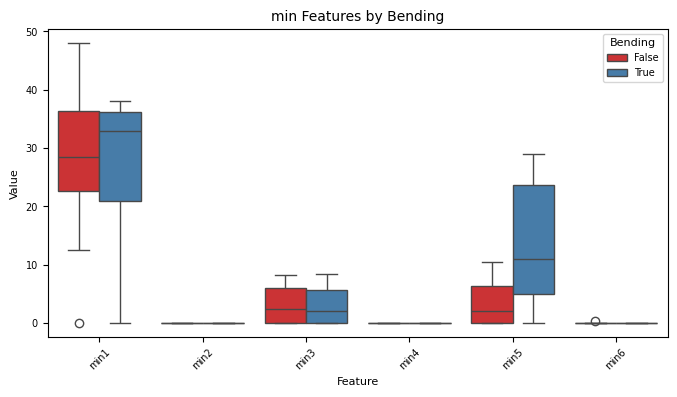

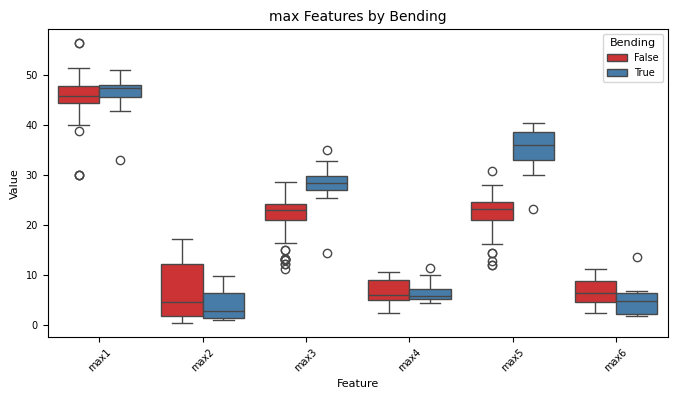

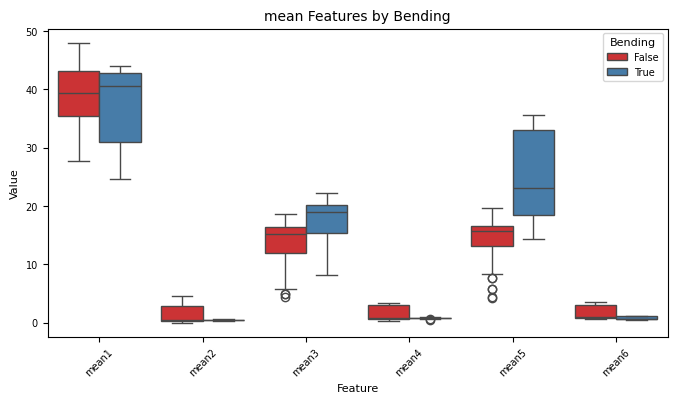

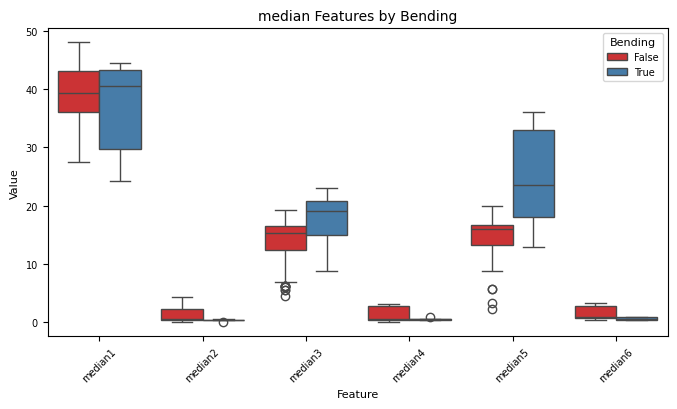

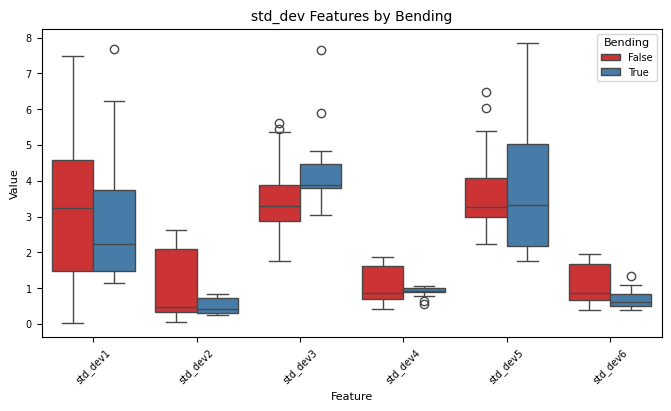

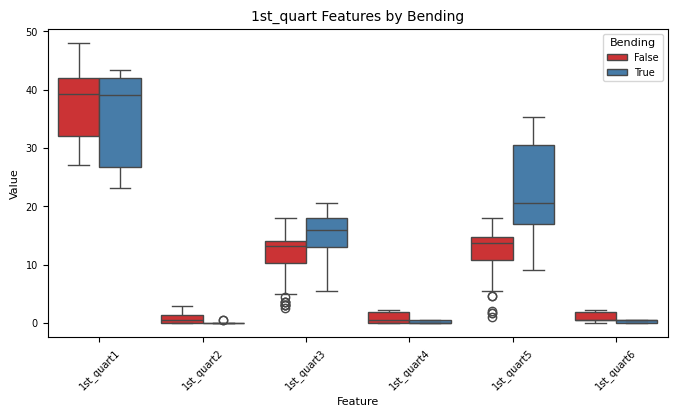

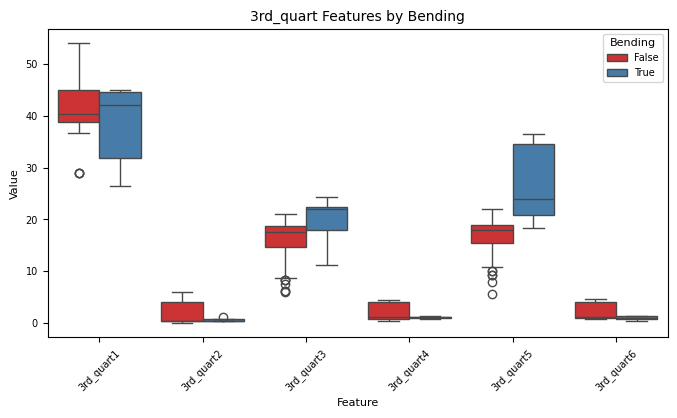

In [97]:
vars = ['min', 'max', 'mean', 'median', 'std_dev', '1st_quart', '3rd_quart']

for var in vars:
    cols = [col for col in df.columns if col.startswith(var)]
    if not cols: continue
    temp = df[cols + ['bin_ind']].melt(id_vars='bin_ind', 
                                         var_name='feature', 
                                         value_name='value')

    plt.figure(figsize=(8, 4))
    sns.boxplot(data=temp, x='feature', y='value', hue='bin_ind', width=0.8, palette='Set1')
    plt.title(f'{var} Features by Bending', fontsize=10)
    plt.xlabel('Feature', fontsize=8)
    plt.ylabel('Value', fontsize=8)
    plt.xticks(rotation=45, fontsize=7)
    plt.yticks(fontsize=7)
    plt.legend(title='Bending', fontsize=7, title_fontsize=8)

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

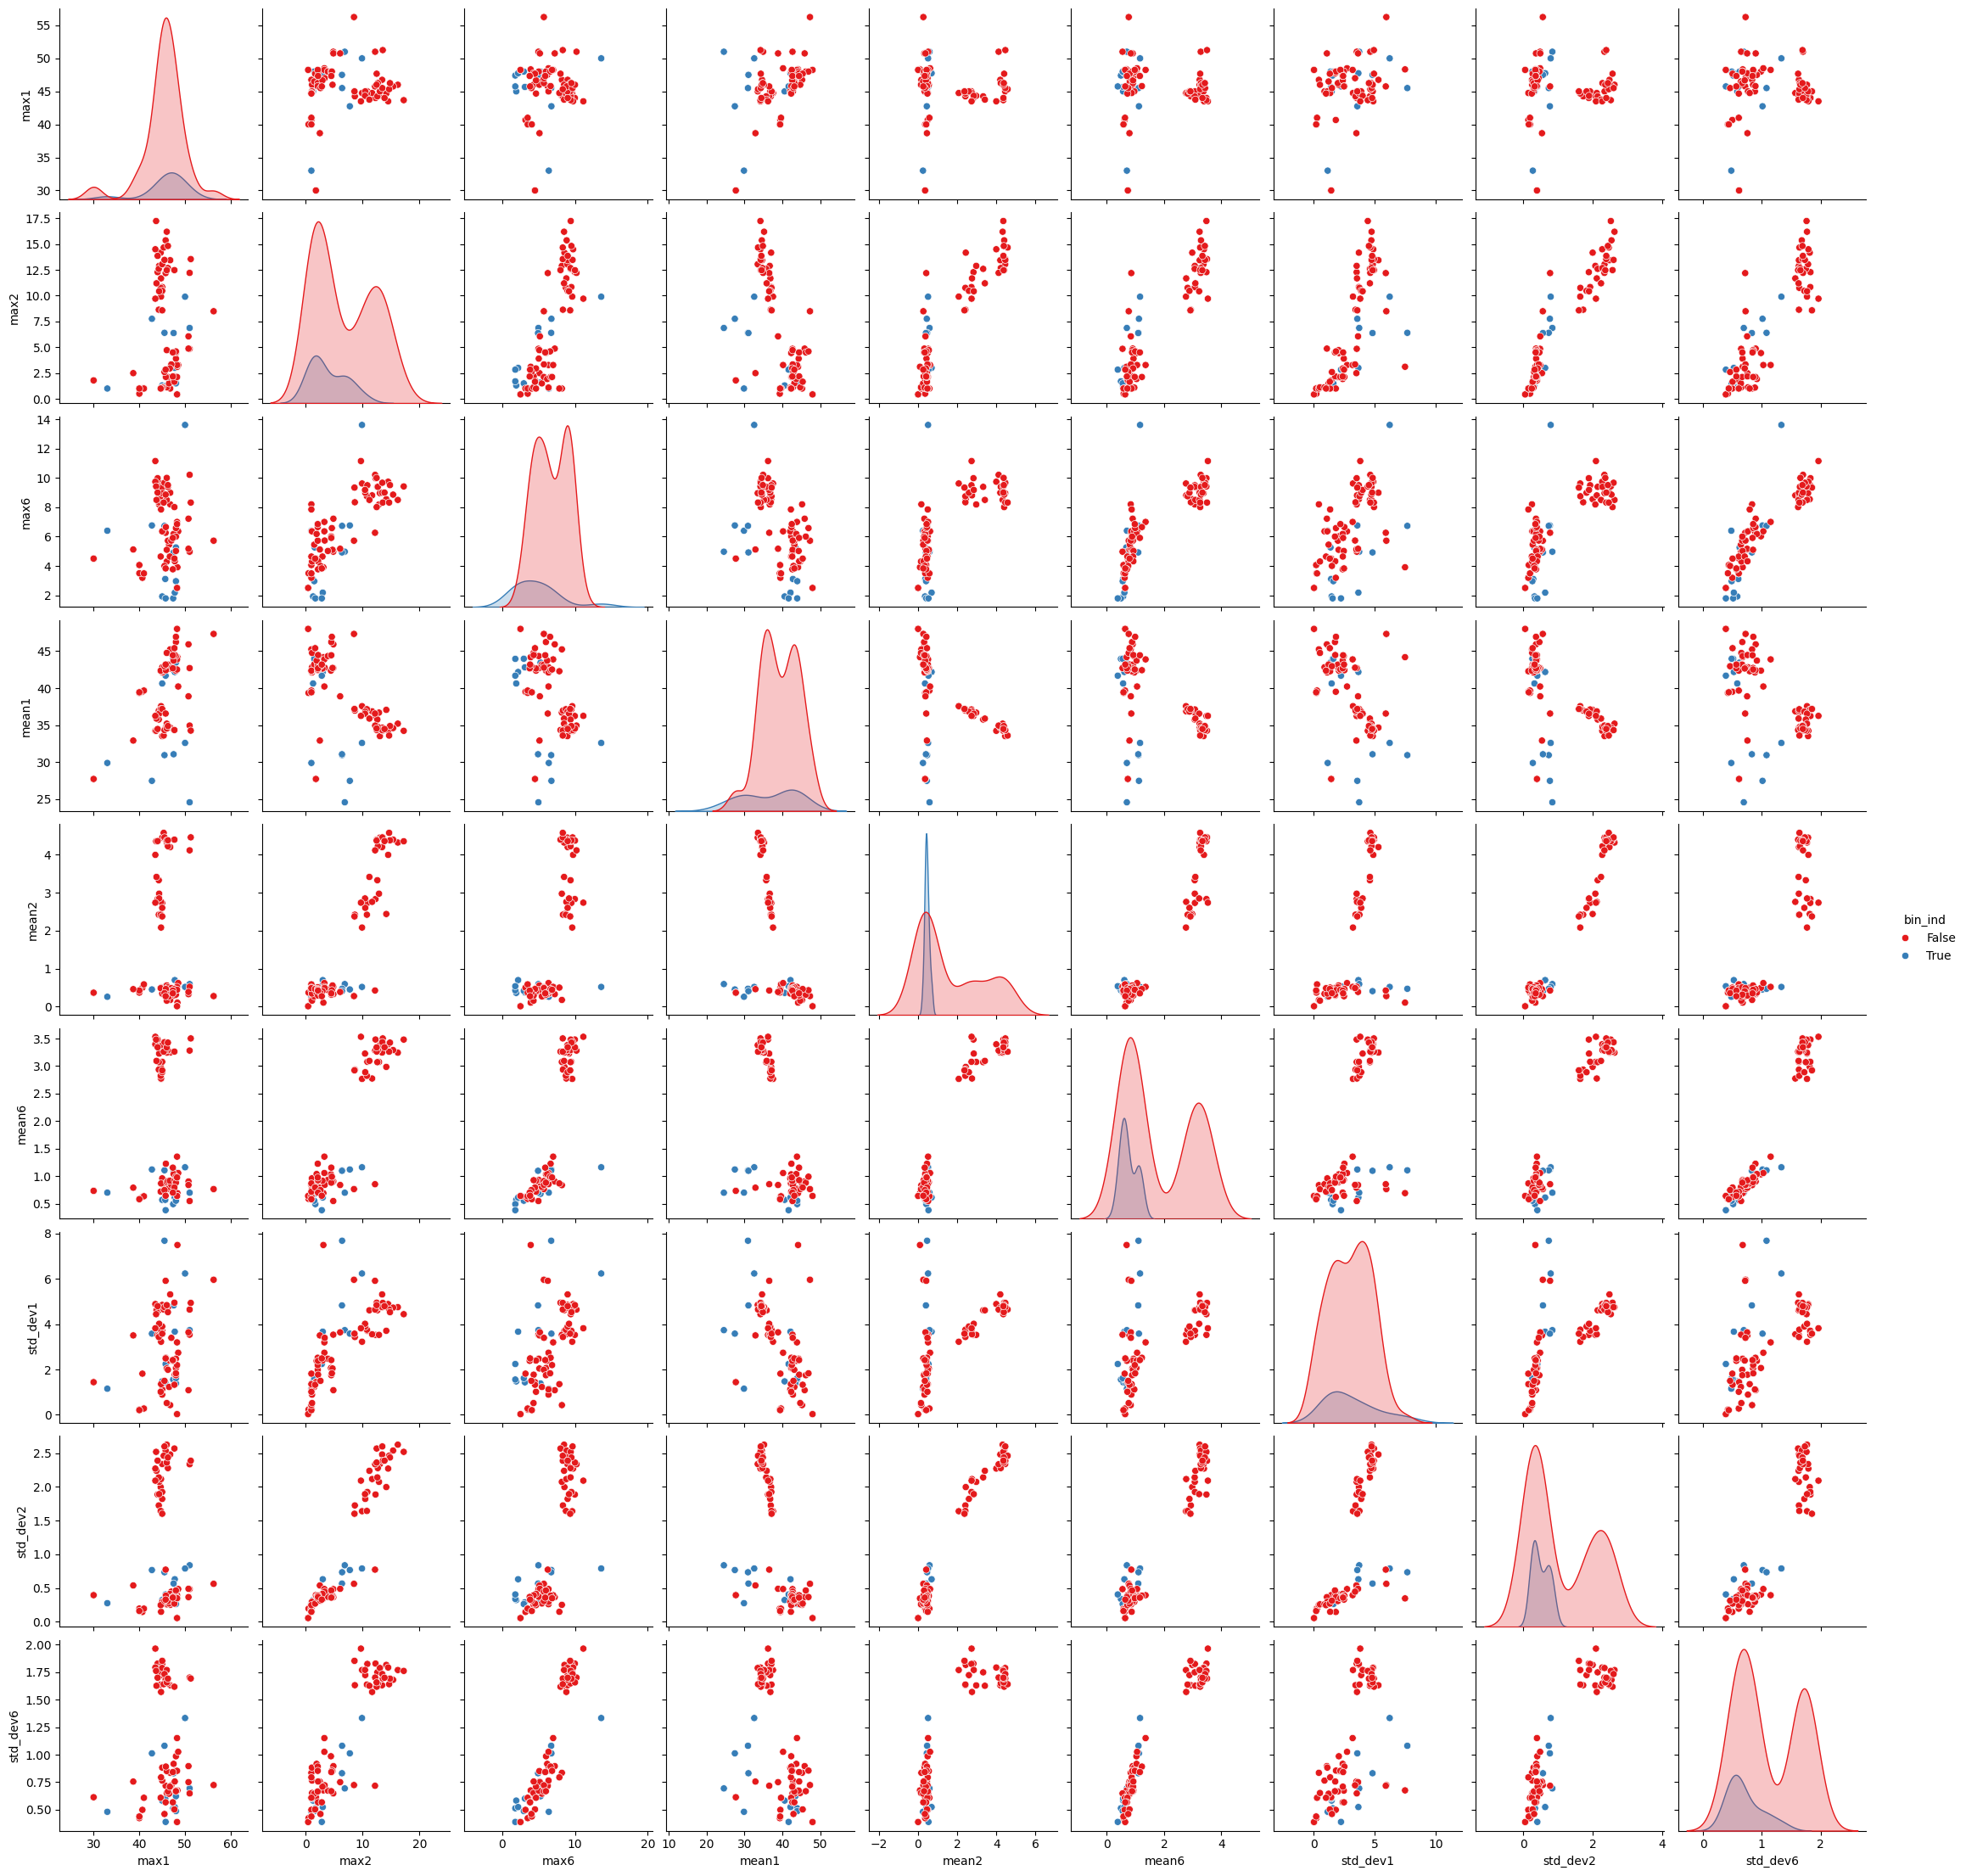

In [98]:
scatter_vars = []
for var in ['max', 'mean', 'std_dev']:
    for num in [1, 2, 6]:
        scatter_vars.append(var + str(num))

sns.pairplot(data=df[scatter_vars + ['bin_ind']], hue='bin_ind', palette='Set1')

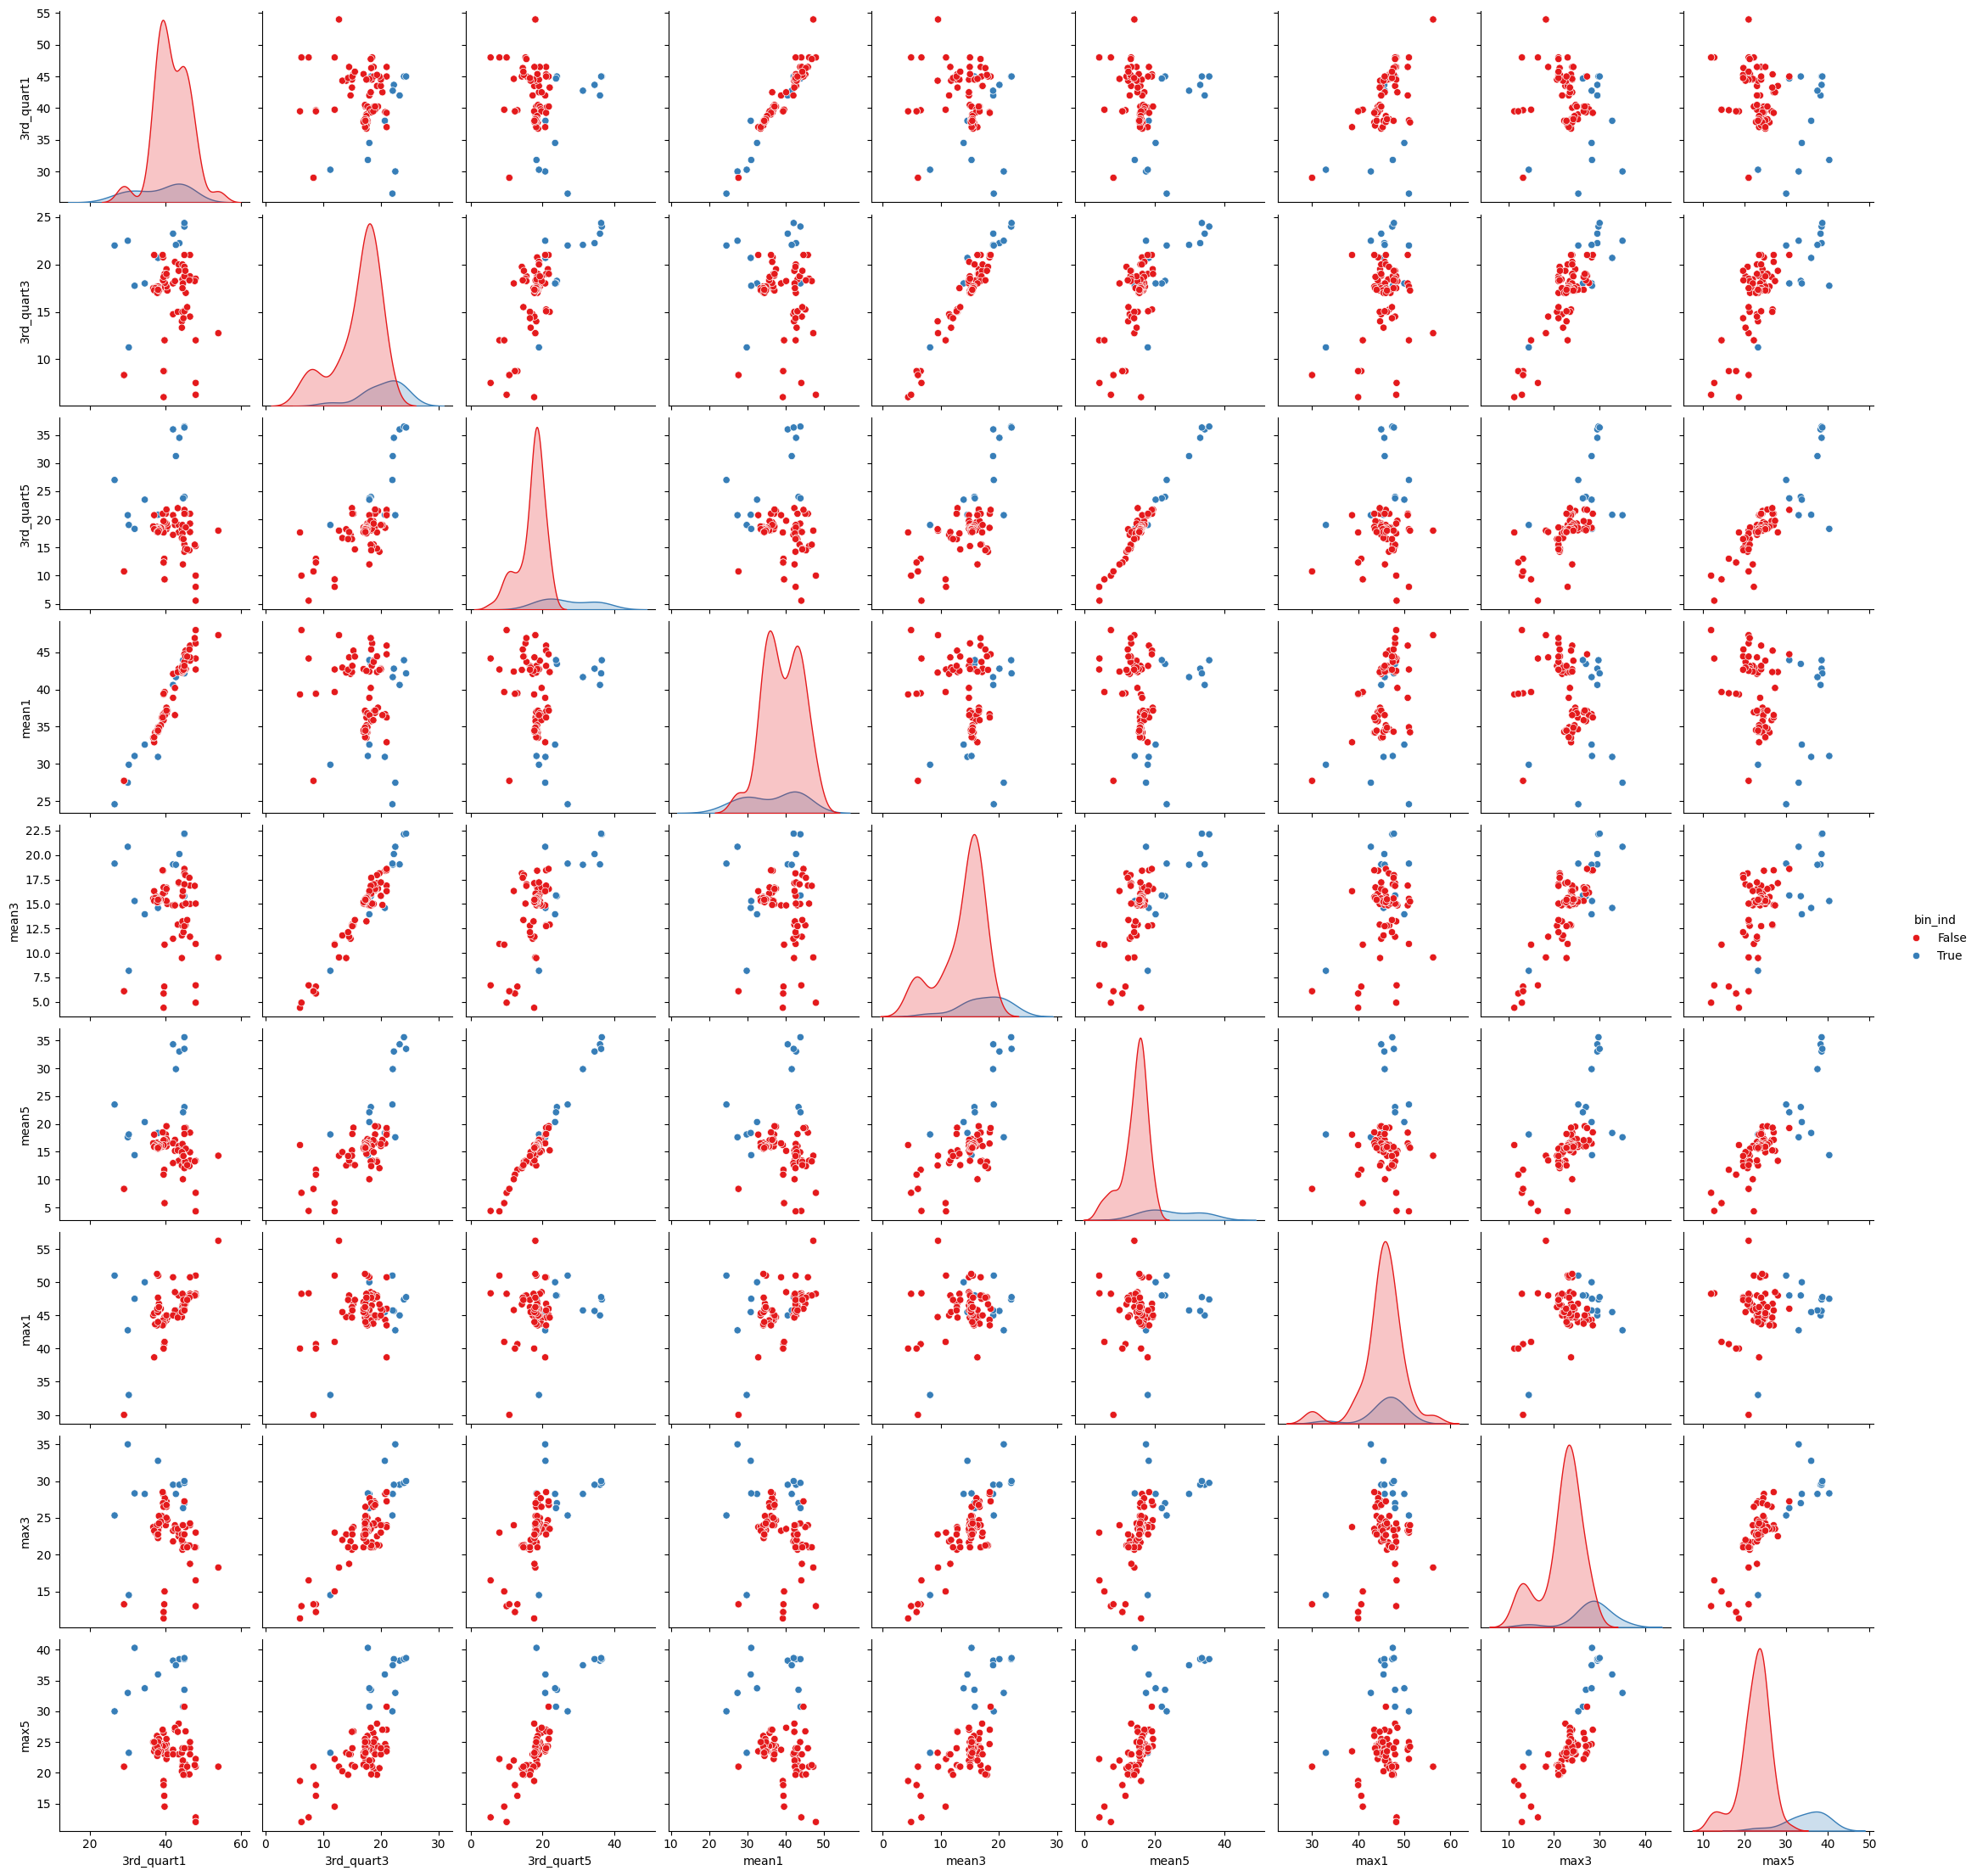

In [99]:
scatter_vars_personal = []
for var in ['3rd_quart', 'mean', 'max']:
    for num in [1, 3, 5]:
        scatter_vars_personal.append(var + str(num))

sns.pairplot(data=df[scatter_vars_personal + ['bin_ind']], hue='bin_ind', palette='Set1')

#### ii. Splitted Plots

In [100]:
train_split = {}
test_split = {}

# separate df just for this question
for dict in [train_data, test_data]:
    for id, dataframe in dict.items():
        part1 = dataframe.iloc[:dataframe.shape[0] // 2]
        part2 = dataframe.iloc[dataframe.shape[0] // 2:]

        if dict == train_data:
            train_split[id + '_part1'] = part1
            train_split[id + '_part2'] = part2
        else:
            test_split[id + '_part1'] = part1
            test_split[id + '_part2'] = part2

train_split = extract_features(train_split)
test_split = extract_features(test_split)
data_split = train_split | test_split

train_split = pd.DataFrame(train_split).T
test_split = pd.DataFrame(test_split).T
data_split = pd.DataFrame(data_split).T

for dataframe in [train_split, test_split, data_split]:
    dataframe['bin_ind'] = [i.startswith('bending') for i in dataframe.index]
    dataframe['multiclass'] = [class_map.get(i.split('_')[0]) for i in dataframe.index]



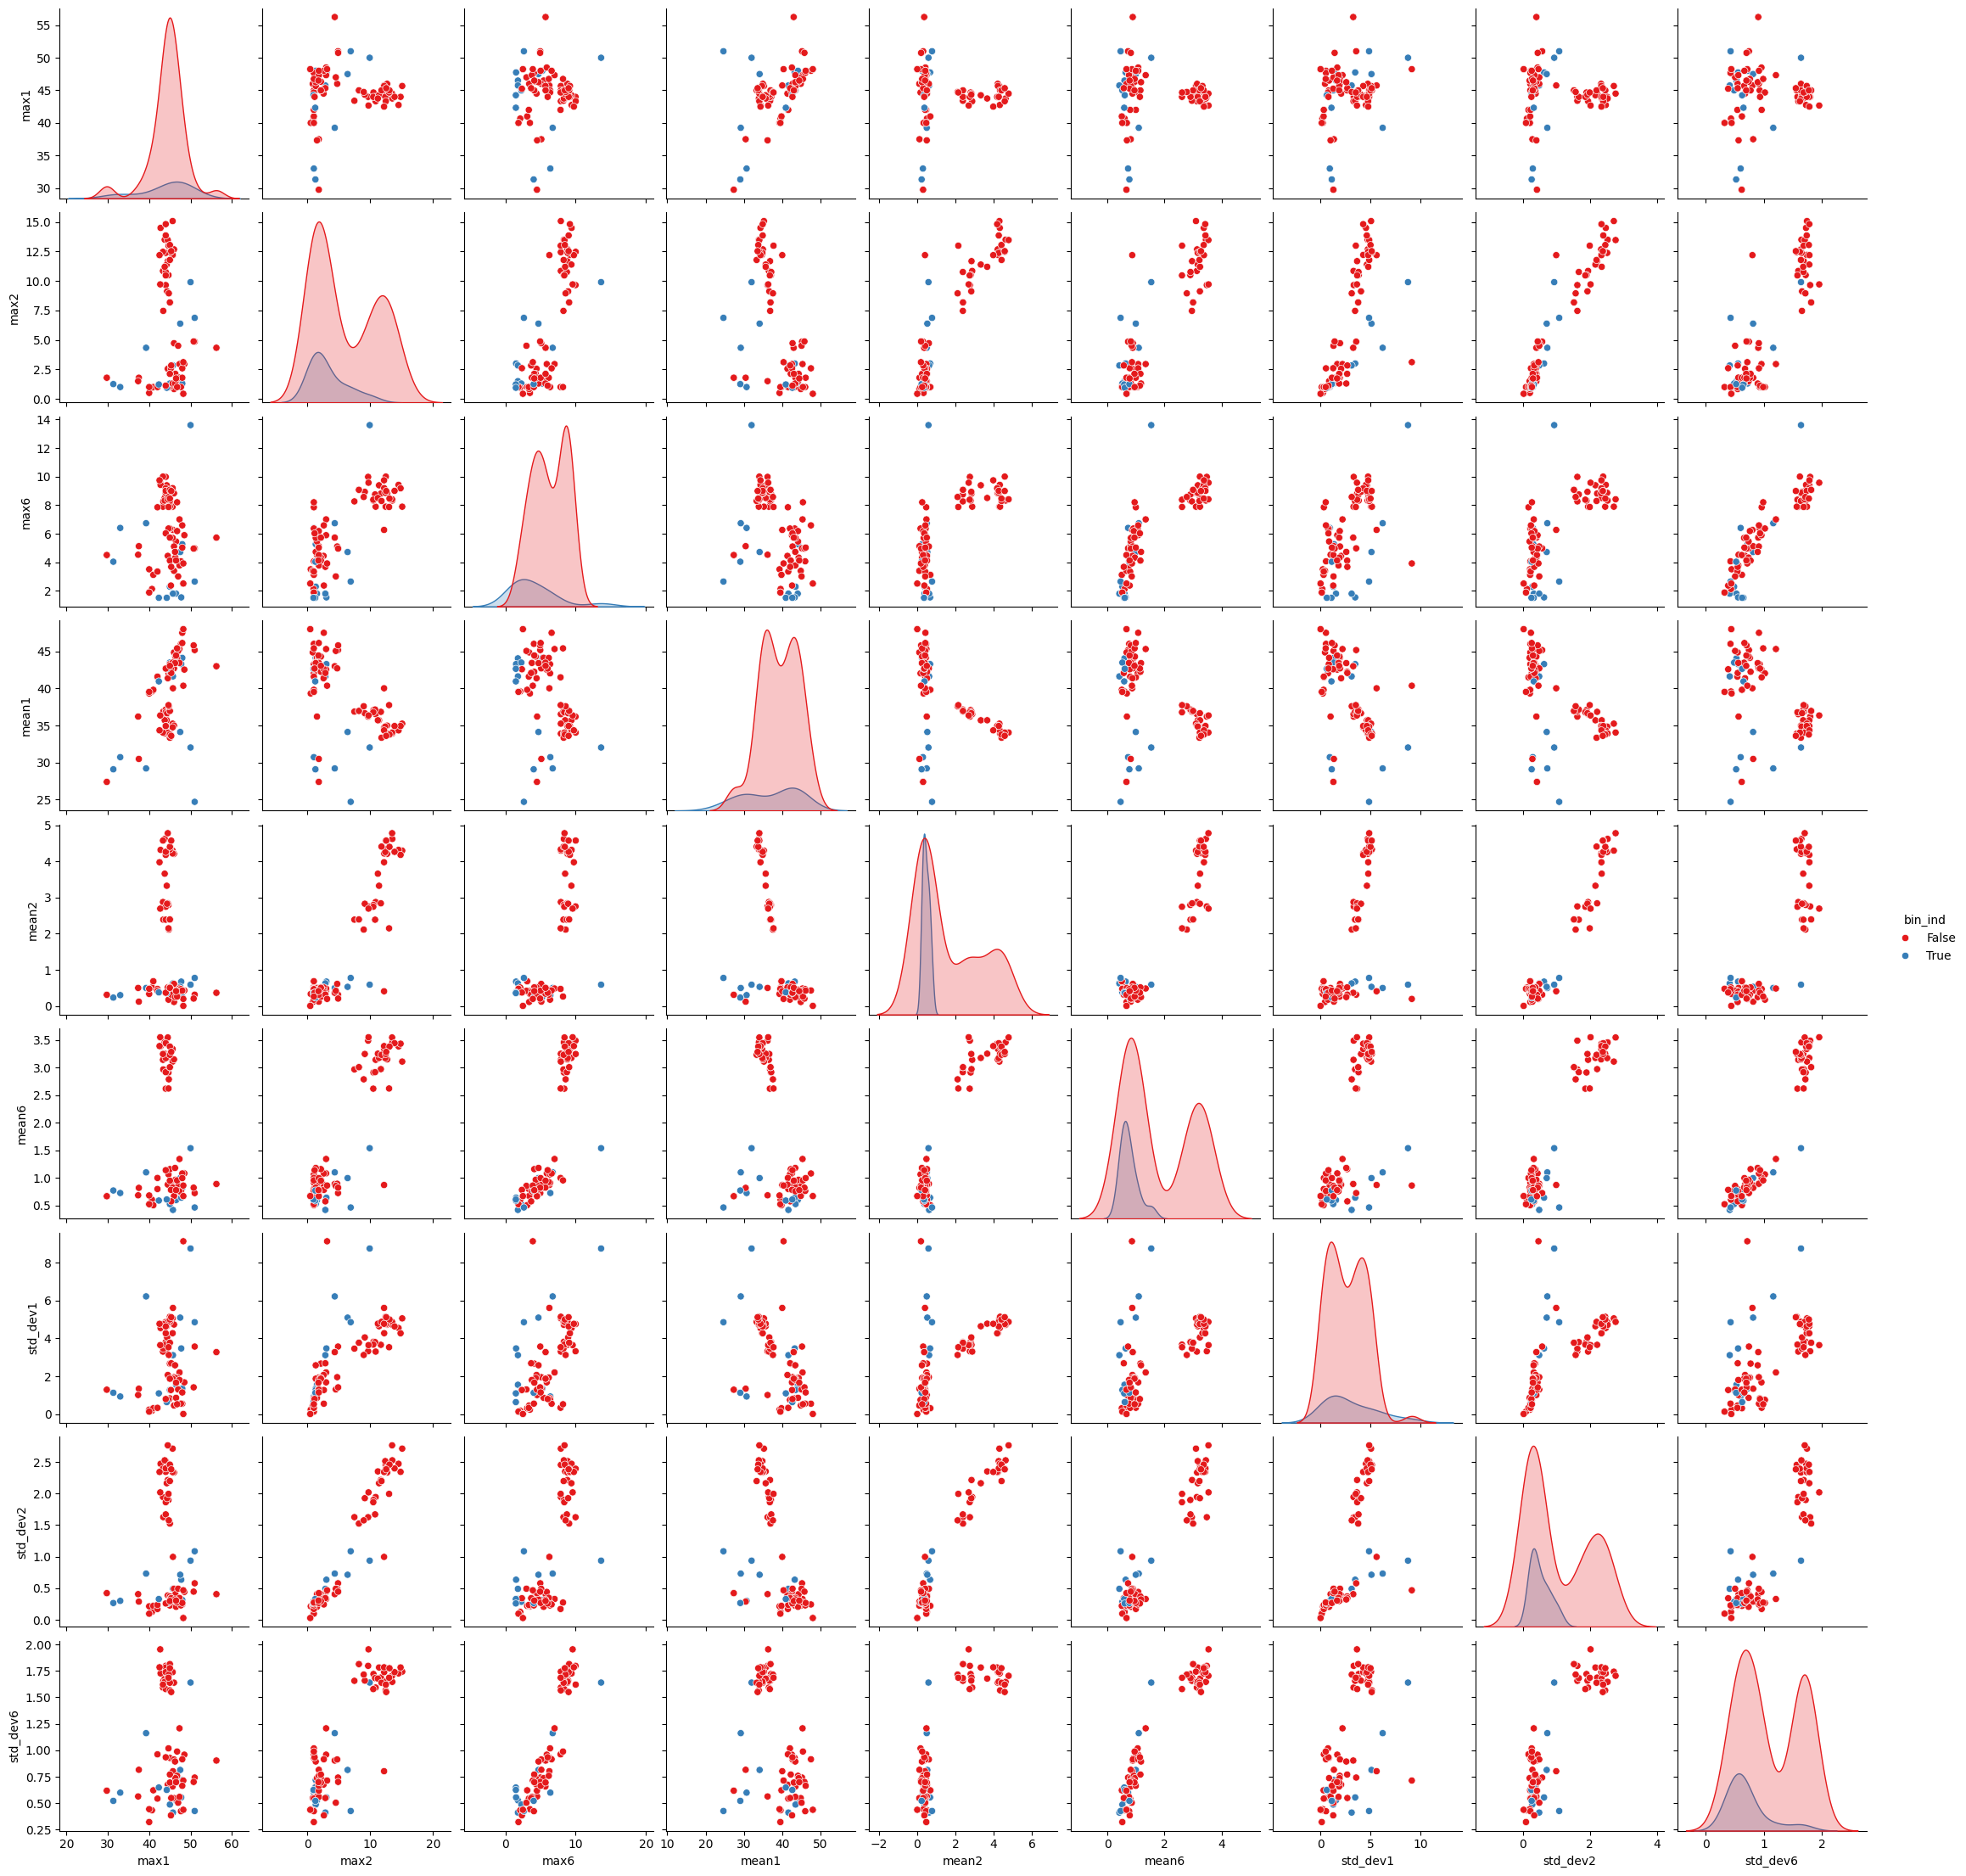

In [101]:
sns.pairplot(data=data_split.loc[data_split.index.str.endswith('1')][scatter_vars + ['bin_ind']], hue='bin_ind', palette='Set1')

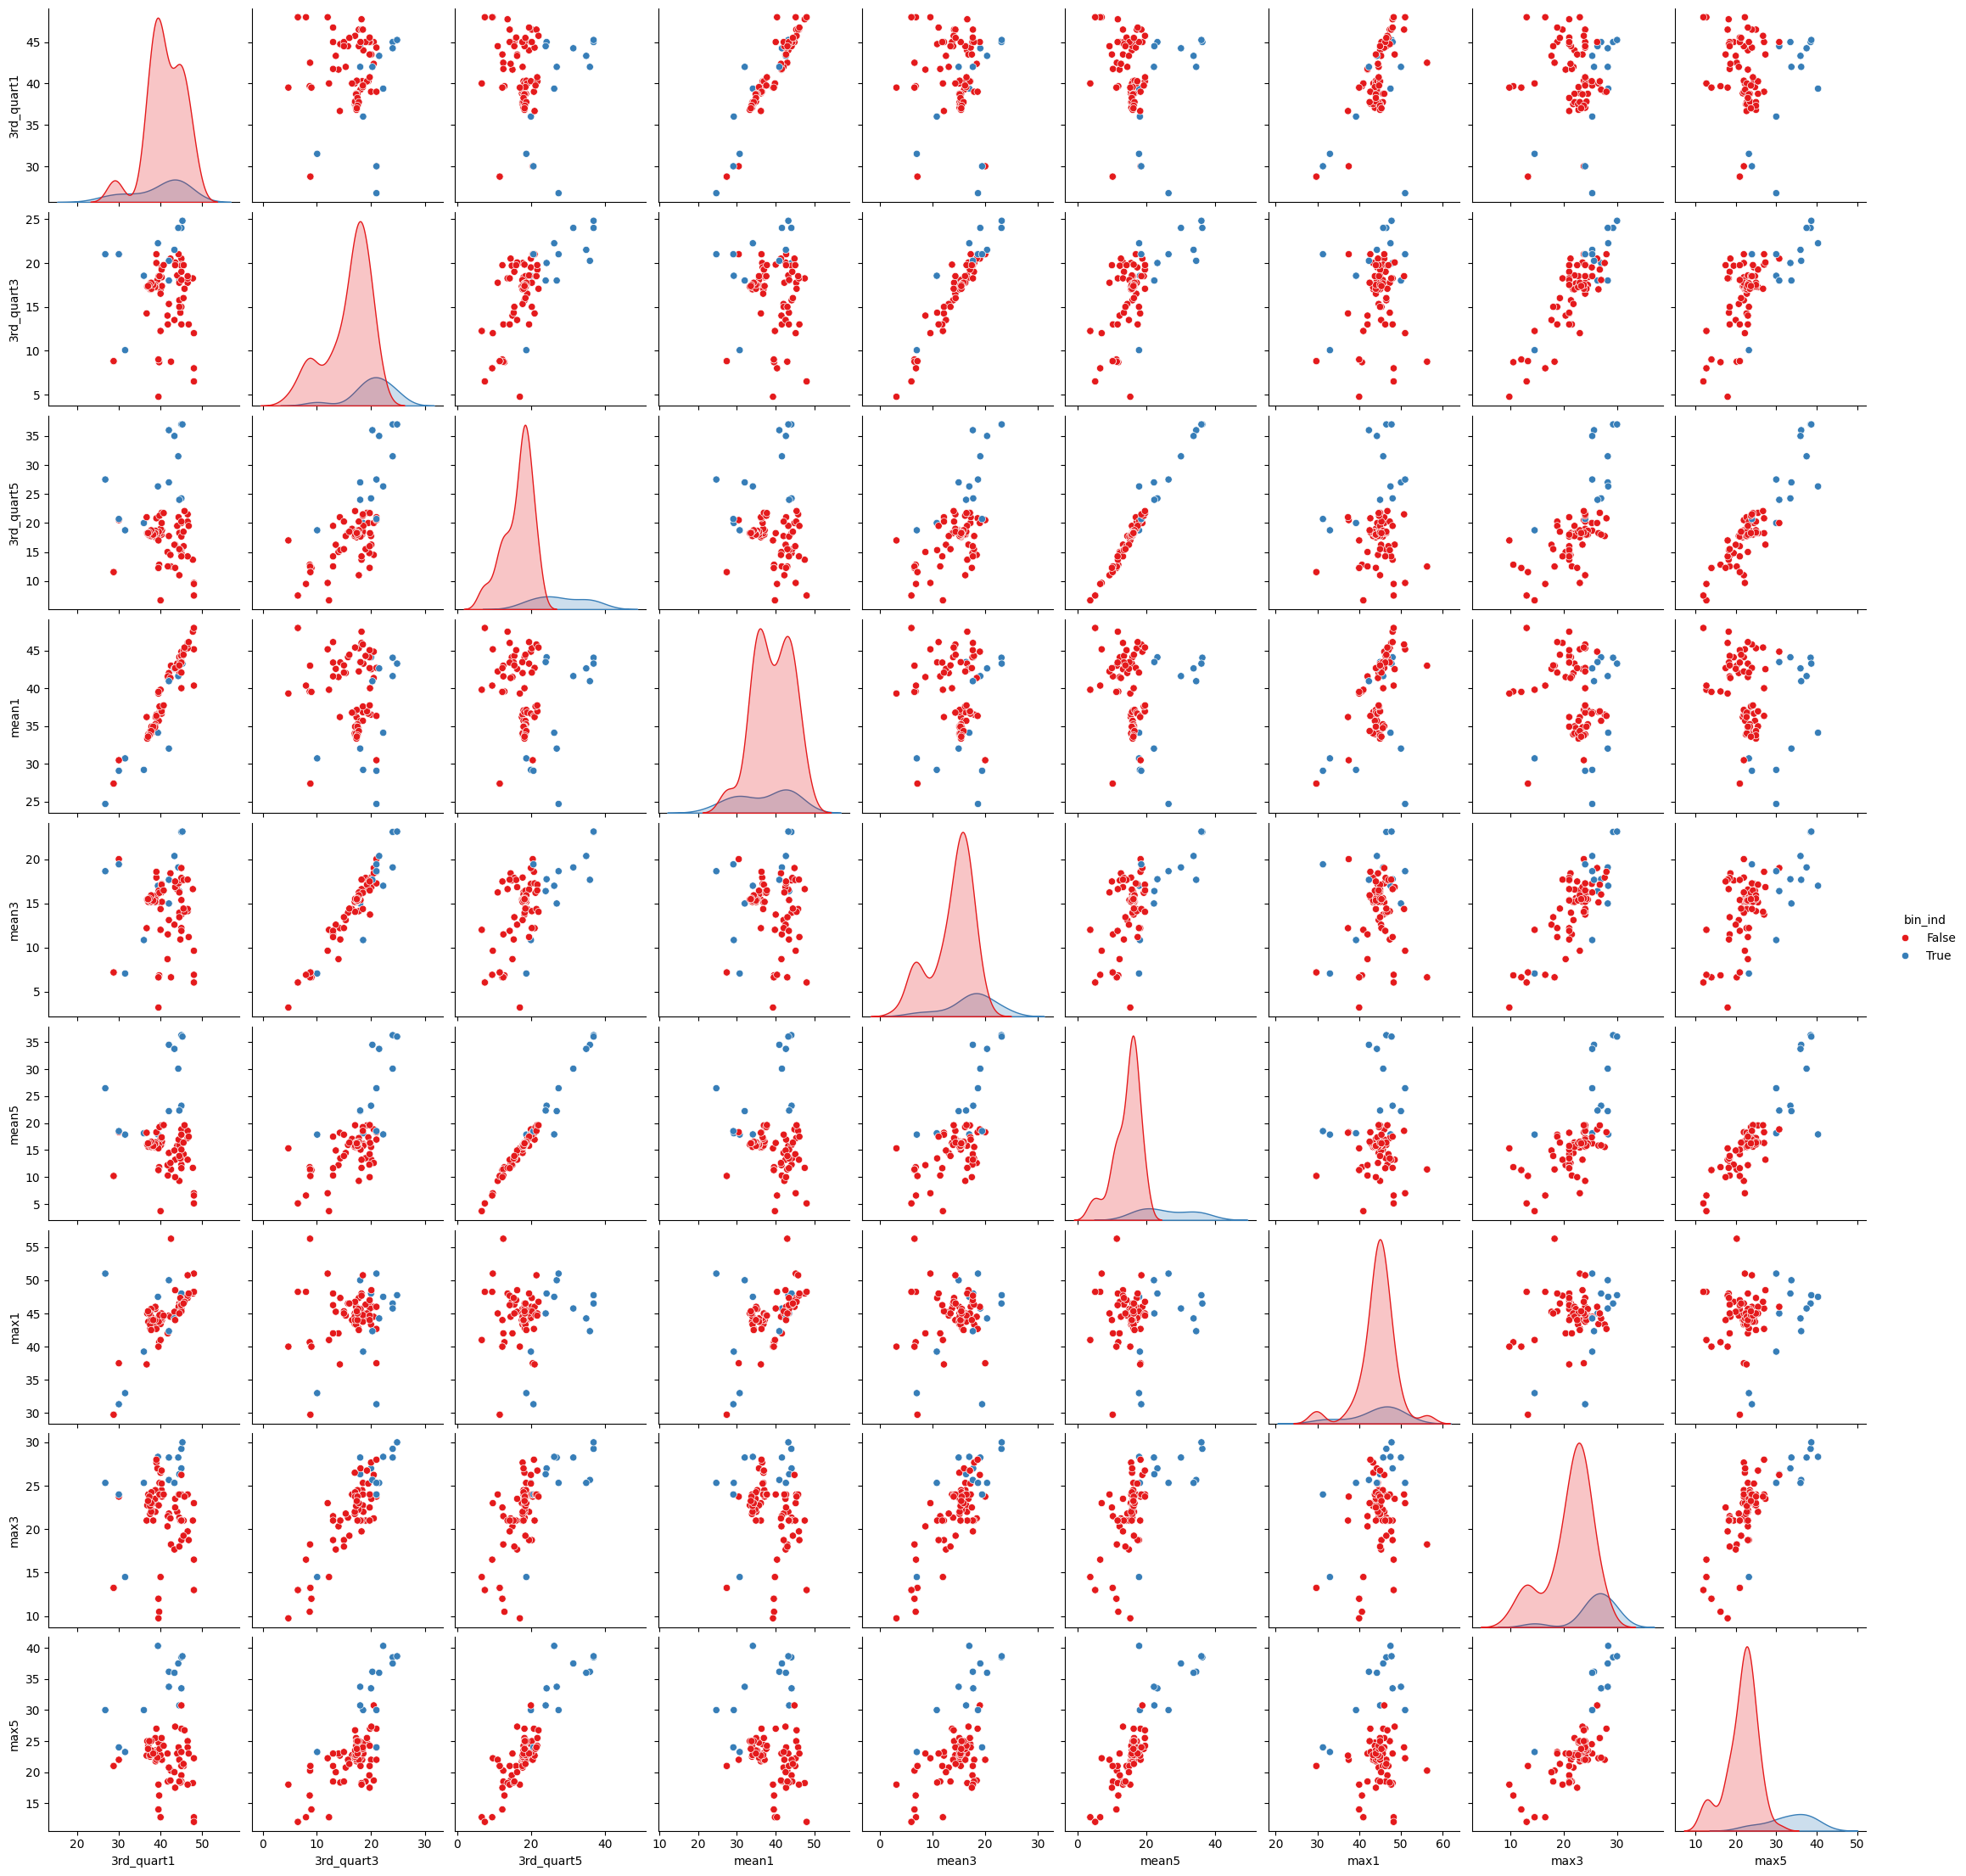

In [102]:
sns.pairplot(data=data_split.loc[data_split.index.str.endswith('1')][scatter_vars_personal + ['bin_ind']], hue='bin_ind', palette='Set1')

I see no considerable difference when comparing the first half of the datasets to the second in generated time-series features for the binary problem. Based off of the boxplots, time-series 2 and 6 are not that great at predicting, but 1, 3, and 5 are. 3rd_quart, mean, and max for 1,3, and 5 seem to give the most information about the binary problem.

#### iii. Time Series Segments

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

length_list = list(range(1, 21))
bin_models = {}
derived_datasets = {}


for dict in [train_data, test_data]:
    for key in dict:
        dict[key] = dict[key].drop(columns=['time'])

for length in length_list:
    train_split = {}
    test_split = {}

    for dict in [train_data, test_data]:
        for id, dataframe in dict.items():
            temp = pd.DataFrame()
            chunk_size = dataframe.shape[0] // length
            for i in range(length):
                start = i * chunk_size
                end = (i + 1) * chunk_size if i < length - 1 else dataframe.shape[0]
                chunk = dataframe.iloc[start:end]
                chunk = chunk.add_suffix(f'_{i}')
                temp = pd.concat([temp, chunk], axis=1)                

            if dict == train_data:
                train_split[id] = temp
            else:
                test_split[id] = temp

    train_split = extract_features(train_split, 1)
    test_split = extract_features(test_split, 1)

    train_split = pd.DataFrame(train_split).T
    test_split = pd.DataFrame(test_split).T

    # training split fit but not transformed for lookahead bias with stratified cross validation, transformed here
    scaler = sci.preprocessing.StandardScaler()
    train_split = pd.DataFrame(scaler.fit(train_split), index=train_split.index, columns=train_split.columns)
    test_split = pd.DataFrame(scaler.transform(test_split), index=test_split.index, columns=test_split.columns)

    for dataframe in [train_split, test_split, data_split]:
        dataframe['bin_ind'] = [i.startswith('bending') for i in dataframe.index]
        dataframe['multiclass'] = [class_map.get(i.split('_')[0]) for i in dataframe.index]

    pipeline = Pipeline([
        ('scaler', sci.preprocessing.StandardScaler()),
        ('model', LogisticRegression(max_iter=1000, penalty=None, solver='saga'))
    ])

    model = LogisticRegression(max_iter=1000, penalty=None, solver='saga')
    rfecv = RFECV(estimator=pipeline, step=1, cv=sci.model_selection.StratifiedKFold(5), scoring='accuracy')
    rfecv.fit(train_split.drop(columns=['bin_ind', 'multiclass']), train_split['bin_ind'])

    y_hat_train = rfecv.predict(train_split.drop(columns=['bin_ind', 'multiclass']))
    y_hat_test = rfecv.predict(test_split.drop(columns=['bin_ind', 'multiclass']))

    derived_datasets[i] = [train_split, test_split]
    bin_models[i] = rfecv

    print("L:", length)
    print("Optimal p:", rfecv.n_features_)
    print("Cross-validation accuracy (mean):", rfecv.cv_results_['mean_test_score'][rfecv.n_features_ - 1])
    print("Training R2 score:", r2_score(train_split['bin_ind'], y_hat_train))
    print("Testing R2 score:", r2_score(test_split['bin_ind'], y_hat_test))
    print()
    

L: 1
Optimal p: 6
Cross-validation accuracy (mean): 0.9714285714285715
Training R2 score: 1.0
Testing R2 score: 1.0

L: 2
Optimal p: 5
Cross-validation accuracy (mean): 0.956043956043956
Training R2 score: 1.0
Testing R2 score: 1.0

L: 3
Optimal p: 1
Cross-validation accuracy (mean): 0.9571428571428571
Training R2 score: 0.6166666666666669
Testing R2 score: 0.050000000000000155

L: 4
Optimal p: 1
Cross-validation accuracy (mean): 0.9428571428571428
Training R2 score: 0.48888888888888915
Testing R2 score: 0.3666666666666668

L: 5
Optimal p: 1
Cross-validation accuracy (mean): 0.9428571428571428
Training R2 score: -0.14999999999999925
Testing R2 score: -0.2666666666666664

L: 6
Optimal p: 1
Cross-validation accuracy (mean): 0.9571428571428571
Training R2 score: 0.6166666666666669
Testing R2 score: 0.6833333333333333

L: 7
Optimal p: 4
Cross-validation accuracy (mean): 0.9428571428571428
Training R2 score: 1.0
Testing R2 score: 0.3666666666666668

L: 8
Optimal p: 1
Cross-validation accura

Models with l = 1, 2, 11, 12, 17, 18, 19, 20 all have the highest cross validation accuracies at .971. I will then run them all for the following.

In [ ]:
true_MLE_L = [2, 3, 4, 5, 7, 15, 16, 19]

for i in range(0, 20):
    selected = derived_datasets.get(i)[0].drop(columns=['multiclass', 'bin_ind']).columns[bin_models.get(i).support_]
    betas = pd.Series(bin_models.get(i).estimator_.coef_[0], index=selected)

    print("\nL:", i + 1)
    print("\nP-values: ",end='')

    if true_MLE_L.count(i) == 1:
        print('')
        x = sm.add_constant(derived_datasets.get(i)[0][list(selected)])
        temp_model = sm.Logit(derived_datasets.get(i)[0]['bin_ind'], x)
        print(temp_model.fit(maxiter=1000).pvalues)

    else:
        print('(Undefined); Sklearn Approx. to MLE')

    

    print("\nBeta Coefficients:")
    for feature, coefficient in betas.items():
        print(feature, '=', coefficient)

    print("\n-----------------------------")


L: 1

P-values: (Undefined); Sklearn Approx. to MLE

Beta Coefficients:
3rd_quart1 = -3.1705923028910945
1st_quart4 = -1.1154535130754666
min5 = 3.594671384590196
max5 = 4.158943613055691
mean5 = 2.2789739637475943
1st_quart6 = -1.4741759528590972

-----------------------------

L: 2

P-values: (Undefined); Sklearn Approx. to MLE

Beta Coefficients:
median1 = -2.82696952305658
min5 = 4.306155924015168
max5 = 4.545099895782322
mean5 = 1.7078245907353558
std_dev12 = -2.8895455224453244

-----------------------------

L: 3

P-values: 
Optimization terminated successfully.
         Current function value: 0.053669
         Iterations 13
const    0.157977
mean5    0.191355
dtype: float64

Beta Coefficients:
mean5 = 13.750570931434309

-----------------------------

L: 4

P-values: 
Optimization terminated successfully.
         Current function value: 0.086347
         Iterations 10
const         0.003357
1st_quart5    0.012701
dtype: float64

Beta Coefficients:
1st_quart5 = 7.159969292390

#### Right and wrongs to CV:
- Right
    - Make sure to standardize variables - use same standardizer trained on training data  in folds to infer on validation and test data (no lookahead bias in training)
    - Stratified CV: CV where folds maintain the original class split. In this case: ~14.8% to ~85.2%, assuring an equal split of the 9 available training bending classes to be distributed over 5 folds (2,2,2,2,1), where none of the folds fail to contain the minority class
- Wrong
    - Not understanding the optimal total number of features may exceed the number of observations in each fold. (5 fold, 69 observations, 14 or 13 observations per fold). This creates a singular Hessian matrix of the Xs in training and therefore breaks your model.

I foresee the LASSO model outperforming these in training and inference

#### iv. Confusion Matrix

Confusion matrix for L = 1:
 [[60  0]
 [ 0  9]] 



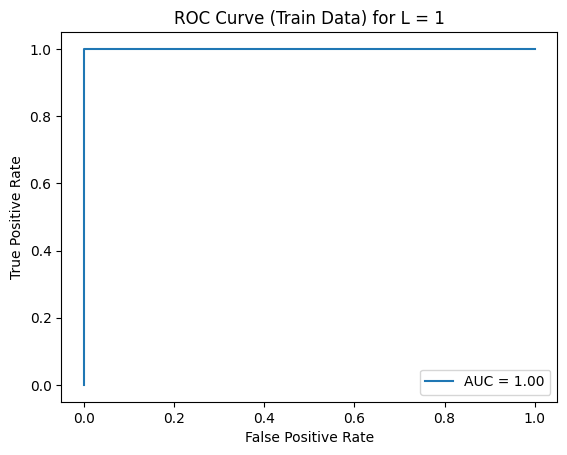

P-values: (Undefined / 1); Sklearn Approx. to MLE

Beta Coefficients:
3rd_quart1 = -3.1705923028910945
1st_quart4 = -1.1154535130754666
min5 = 3.594671384590196
max5 = 4.158943613055691
mean5 = 2.2789739637475943
1st_quart6 = -1.4741759528590972

--------------------

Confusion matrix for L = 2:
 [[60  0]
 [ 0  9]] 



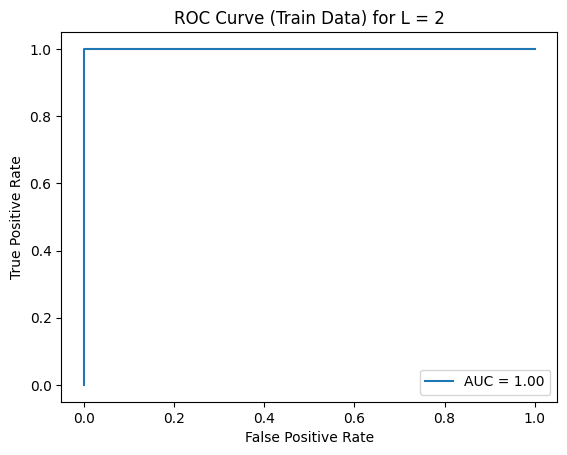

P-values: (Undefined / 1); Sklearn Approx. to MLE

Beta Coefficients:
median1 = -2.82696952305658
min5 = 4.306155924015168
max5 = 4.545099895782322
mean5 = 1.7078245907353558
std_dev12 = -2.8895455224453244

--------------------

Confusion matrix for L = 11:
 [[60  0]
 [ 0  9]] 



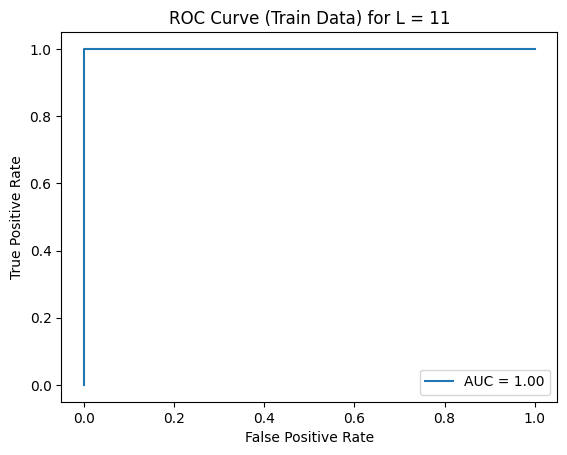

P-values: (Undefined / 1); Sklearn Approx. to MLE

Beta Coefficients:
mean11 = 2.015739922352905
1st_quart11 = 6.448867217803318
max23 = 3.2262725104887946
min59 = 4.117799602610895

--------------------

Confusion matrix for L = 12:
 [[60  0]
 [ 0  9]] 



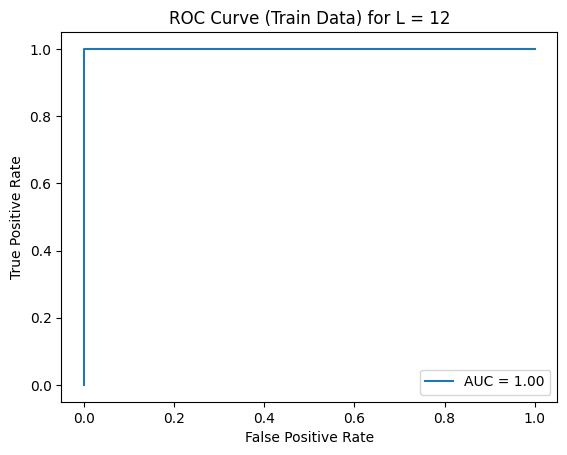

P-values: (Undefined / 1); Sklearn Approx. to MLE

Beta Coefficients:
median11 = 4.026331674081431
1st_quart11 = 5.100644257623784
min65 = 5.05273873582674

--------------------

Confusion matrix for L = 17:
 [[60  0]
 [ 1  8]] 



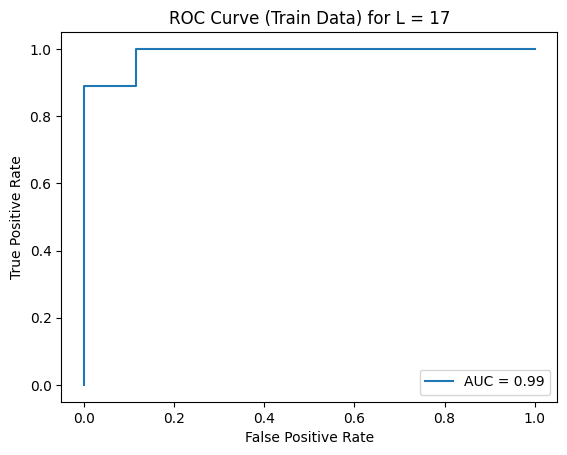

P-values:
Optimization terminated successfully.
         Current function value: 0.068559
         Iterations 10
const     0.003065
mean17    0.011747
dtype: float64

Beta Coefficients:
mean17 = 6.740488375748458

--------------------

Confusion matrix for L = 18:
 [[60  0]
 [ 0  9]] 



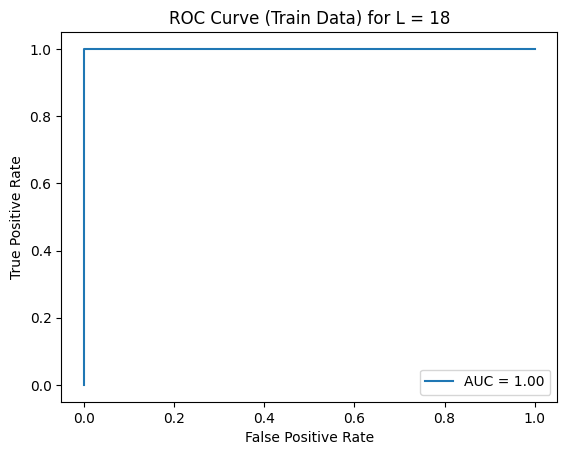

P-values: (Undefined / 1); Sklearn Approx. to MLE

Beta Coefficients:
mean17 = 3.75355194479317
1st_quart17 = 7.50857482462445
std_dev87 = -4.29935151594327

--------------------

Confusion matrix for L = 19:
 [[60  0]
 [ 0  9]] 



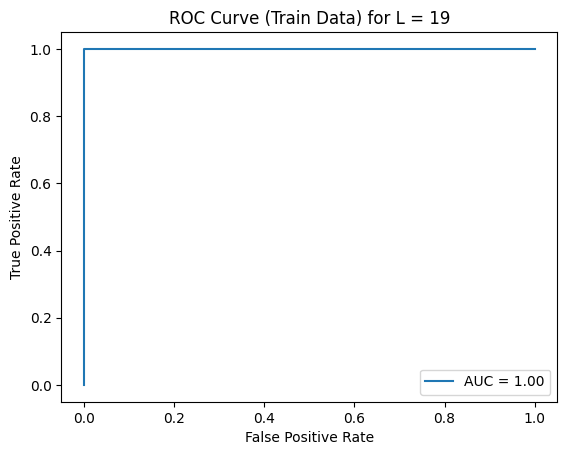

P-values: (Undefined / 1); Sklearn Approx. to MLE

Beta Coefficients:
mean17 = 3.5127726194128894
1st_quart17 = 6.711260646354198
min107 = 3.812428092068981

--------------------

Confusion matrix for L = 20:
 [[59  1]
 [ 1  8]] 



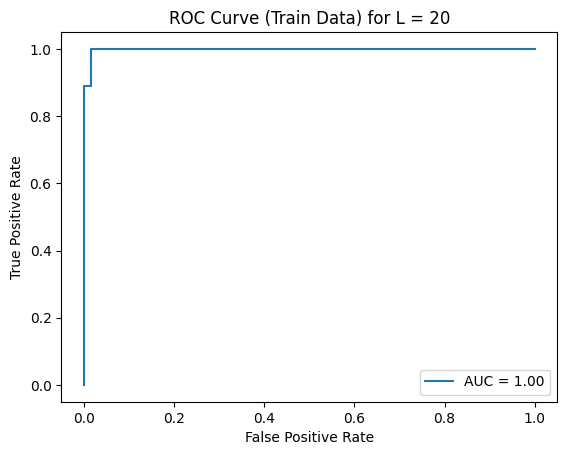

P-values:
Optimization terminated successfully.
         Current function value: 0.051114
         Iterations 11
const          0.013920
1st_quart17    0.031375
dtype: float64

Beta Coefficients:
1st_quart17 = 8.368460034812665

--------------------



In [169]:
best_ls = [0, 1, 10, 11, 16, 17, 18, 19]
names = {
    0: ['3rd_quart1', '1st_quart4', 'min5', 'max5', 'mean5', '1st_quart6'],
    1: ['median1', 'min5', 'max5', 'mean5', 'std_dev12'],
    10: ['mean11', '1st_quart11', 'max23', 'min59'],
    11: ['median11', '1st_quart11', 'min65'],
    16: ['mean17'],
    17: ['mean17', '1st_quart17', 'std_dev87'],
    18: ['mean17', '1st_quart17', 'min107'],
    19: ['1st_quart17']
}

for i in best_ls:
    y_hat = bin_models.get(i).predict(derived_datasets.get(i)[0].drop(columns=['multiclass', 'bin_ind']))

    y_prob = bin_models.get(i).predict_proba(derived_datasets.get(i)[0].drop(columns=['multiclass', 'bin_ind']))[:, 1]
    fp_rate, tp_rate, thresholds = sci.metrics.roc_curve(derived_datasets.get(i)[0]['bin_ind'], y_prob)
    auc = sci.metrics.roc_auc_score(derived_datasets.get(i)[0]['bin_ind'], y_prob)

    print(f"Confusion matrix for L = {i + 1}:\n", sci.metrics.confusion_matrix(derived_datasets.get(i)[0]['bin_ind'], y_hat), '\n')

    plt.plot(fp_rate, tp_rate, label=f"AUC = {auc:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (Train Data) for L = {i + 1}")
    plt.legend()
    plt.show()

    print('P-values:', end='')

    if i == 16 or i == 19:
        print('')
        if i == 16:
            x = sm.add_constant(derived_datasets.get(i)[0]['mean17'])
        else:
            x = sm.add_constant(derived_datasets.get(i)[0]['1st_quart17'])
        temp_model = sm.Logit(derived_datasets.get(i)[0]['bin_ind'], x)
        print(temp_model.fit(maxiter=1000).pvalues)
    else:
        print(" (Undefined / 1); Sklearn Approx. to MLE")

    betas = pd.Series(bin_models.get(i).estimator_.coef_[0], index=names[i])

    print("\nBeta Coefficients:")
    for feature, coefficient in betas.items():
        print(feature, '=', coefficient)

    print('\n--------------------\n')

#### v. Test Classifier

In [172]:
for i in best_ls:
    y_hat_test = bin_models.get(i).predict(derived_datasets.get(i)[1].drop(columns=['bin_ind', 'multiclass']))

    print("L:", i + 1)
    print("Cross-validation accuracy (mean):", bin_models.get(i).cv_results_['mean_test_score'][bin_models.get(i).n_features_ - 1])
    print("Testing accuracy:", sci.metrics.accuracy_score(test_split['bin_ind'], y_hat_test), '\n')

L: 1
Cross-validation accuracy (mean): 0.9714285714285715
Testing accuracy: 1.0 

L: 2
Cross-validation accuracy (mean): 0.956043956043956
Testing accuracy: 1.0 

L: 11
Cross-validation accuracy (mean): 0.9714285714285715
Testing accuracy: 0.9473684210526315 

L: 12
Cross-validation accuracy (mean): 0.9714285714285715
Testing accuracy: 0.9473684210526315 

L: 17
Cross-validation accuracy (mean): 0.9714285714285715
Testing accuracy: 0.8947368421052632 

L: 18
Cross-validation accuracy (mean): 0.9714285714285715
Testing accuracy: 0.9473684210526315 

L: 19
Cross-validation accuracy (mean): 0.9714285714285715
Testing accuracy: 0.8947368421052632 

L: 20
Cross-validation accuracy (mean): 0.9714285714285715
Testing accuracy: 0.9473684210526315 



It seems as though model 1 is the best model, as it has the highest validation and test score. Most of the cross validations are higher than the testing accuracy. This is most likely occuring due to overfitting of the training set, which is small in nature, and unbalanced. Unseen data is likely variable in comparison. The class imbalance for models with fewer features likely causes them to overfit to the majority class to a high degree, and results in poor testing accuracy.

#### vi. Separation

In three quarters of the models the testing accuracy is 100%. This is strong evidence of class separation and suggests potential issues with parameter estimation stability, such as perfect separation causing infinite or non-interpretable logistic regression coefficients.

Statsmodels uses exact Newton-Raphson's true MLE algorithm for logistic regression. Therefore, it fails to converge when using feature sets that exhibit perfect or near-perfect class separation. This is because the algorithm relies on the inverse of the Hessian matrix to compute the beta values, and perfect separation causes the Hessian to become singular (i.e., not full rank / non-invertible).

Sklearn, however, estimates MLE values using gradient descent (the saga approx. algorithm of MLE). Only Sklearn's gradient descent method can produce beta coefficients from a dataset exhibiting separation by implementing early stopping with a max iterations declaration. This allows the model to learn using the gradient-based approximation while avoiding divergence to infinite coefficients caused by the unbounded likelihood under perfect separation.

As the models from this dataset derived from MLE Sklearn approximations in RFE often exhibit separation, they cannot be recreated in statsmodels without modifying the feature space to reduce separation or dropping features that contribute to instability.

Scikit-learn’s saga solver approximates MLE numerically and can still produce stable, predictive models even in these edge cases. They also seem to test and train much better. If the saga/sklearn model performs better on test data, it is preferable for prediction despite being less interpretable. This does however, run the risk of overfitting in its own right, and with such a small dataset in training and inference, one must consider testing bias. Just because it does well on a small subset of testing data, does not mean it is generalized enough for production.

#### vii. Imbalance

There is evidence of class imbalance: there are 60 observations of the majority (non-bending), and 9 observations of the minority in the training set. Although it is not strictly necessary, to maintain interpretability of p-values and the like, I will keep all 9 observations of the minority class, and randomly sample 40 from the majority class. This makes the training set go from ~13% (Imbalanced) to ~18% (Balanced) proportion of the minority class (Based off of lecture). I will use the initial dataset (L=1) without a split due to the fact it was the best performing from the previous models, and I can regress all Xs as p < # of obs


Beta Coefficients:
3rd_quart1 = -3.8005892378891244
min5 = 4.597072100679261
max5 = 6.142839019089987
mean5 = 3.269154697115796

P-Values: (Undefined / 1); Sklearn Approx. to MLE

Confusion matrix for case-controled sample model:
 [[40  0]
 [ 0  9]] 



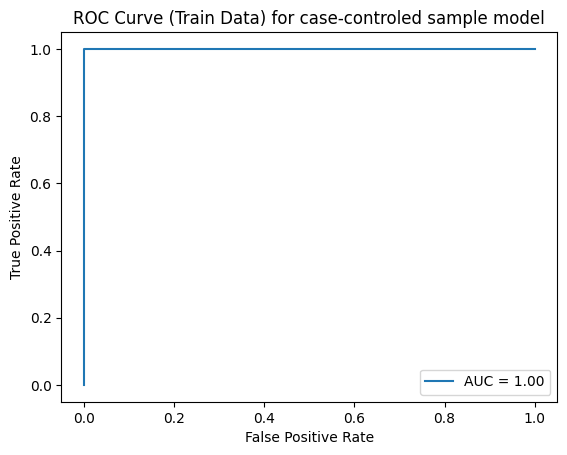

In [221]:
minority = derived_datasets.get(0)[0][derived_datasets.get(1)[0]['bin_ind'] == 1]
majority = derived_datasets.get(0)[0][derived_datasets.get(1)[0]['bin_ind'] == 0]
majority = majority.sample(n=40, random_state=40)

# training split fit but not transformed for lookahead bias with stratified cross validation, transformed here
scaler = sci.preprocessing.StandardScaler()
case_control_dataset = pd.concat([minority, majority])
x = case_control_dataset.drop(columns=['bin_ind', 'multiclass'])
x = pd.DataFrame(scaler.fit_transform(x), index=x.index, columns=x.columns)

model = LogisticRegression(max_iter=1000, penalty=None, solver='saga')
rfe = RFECV(estimator=model, step=1, scoring='accuracy', cv=5)
rfe.fit(x, case_control_dataset['bin_ind'])

selected = x.columns[rfe.support_]
betas = pd.Series(rfe.estimator_.coef_[0], index=selected)

print("\nBeta Coefficients:")
for feature, coefficient in betas.items():
    print(feature, '=', coefficient)

print("\nP-Values: (Undefined / 1); Sklearn Approx. to MLE\n")

y_hat = rfe.predict(case_control_dataset.drop(columns=['multiclass', 'bin_ind']))
y_prob = rfe.predict_proba(case_control_dataset.drop(columns=['multiclass', 'bin_ind']))[:, 1]
fp_rate, tp_rate, thresholds = sci.metrics.roc_curve(case_control_dataset['bin_ind'], y_prob)
auc = sci.metrics.roc_auc_score(case_control_dataset['bin_ind'], y_prob)

print(f"Confusion matrix for case-controled sample model:\n", sci.metrics.confusion_matrix(case_control_dataset['bin_ind'], y_hat), '\n')

plt.plot(fp_rate, tp_rate, label=f"AUC = {auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Train Data) for case-controled sample model")
plt.legend()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [227]:
l1_models = {}

for i in list(range(20)):
    pipeline = Pipeline([
        ('scaler', sci.preprocessing.StandardScaler()),
        ('model', sci.linear_model.LogisticRegressionCV(max_iter=1000, penalty='l1', cv=sci.model_selection.StratifiedKFold(5), solver='liblinear'))
    ])

    x = derived_datasets.get(i)[0].drop(columns=['bin_ind', 'multiclass'])
    y = derived_datasets.get(i)[0]['bin_ind']

    pipeline.fit(x, y)

    y_hat_train = pipeline.predict(x)
    y_hat_test = pipeline.predict(derived_datasets.get(i)[1].drop(columns=['bin_ind', 'multiclass']))

    l1_models[i] = pipeline

    print("L:", i + 1)
    print("Optimal C:", pipeline.named_steps['model'].C_[0])
    print("Optimal p:", sum(pipeline.named_steps['model'].coef_[0] != 0))
    print("Cross-validation accuracy (mean):", pipeline.named_steps['model'].scores_[1].mean(axis=0)[list(pipeline.named_steps['model'].Cs_).index(pipeline.named_steps['model'].C_[0])])
    print("Training Accuracy score:", sci.metrics.accuracy_score(y, y_hat_train))
    print("Testing Accuracy score:", sci.metrics.accuracy_score(derived_datasets.get(i)[1][['bin_ind']], y_hat_test))
    
    print("\n-----------------\n")

L: 1
Optimal C: 2.782559402207126
Optimal p: 8
Cross-validation accuracy (mean): 0.9714285714285715
Training Accuracy score: 1.0
Testing Accuracy score: 1.0

-----------------

L: 2
Optimal C: 2.782559402207126
Optimal p: 10
Cross-validation accuracy (mean): 0.9571428571428571
Training Accuracy score: 1.0
Testing Accuracy score: 0.9473684210526315

-----------------

L: 3
Optimal C: 0.3593813663804626
Optimal p: 7
Cross-validation accuracy (mean): 0.9714285714285715
Training Accuracy score: 0.9710144927536232
Testing Accuracy score: 0.9473684210526315

-----------------

L: 4
Optimal C: 2.782559402207126
Optimal p: 10
Cross-validation accuracy (mean): 0.9571428571428571
Training Accuracy score: 1.0
Testing Accuracy score: 0.9473684210526315

-----------------

L: 5
Optimal C: 0.3593813663804626
Optimal p: 8
Cross-validation accuracy (mean): 0.9274725274725275
Training Accuracy score: 0.9855072463768116
Testing Accuracy score: 0.9473684210526315

-----------------

L: 6
Optimal C: 21.54

P-values are not reported from l1 regression as they are not mathematically sound / interpretable due to the additive bias.

#### ii. Comparison

The l1-penalized logistic regression performs about the same as the RFE models (when they work). L1 retains the variables highly correlated with Y while shrinking multicollinear features coefficients to zero (penalizing model complexity) while the RFE model is purely a greedy algorithm. L1's resulting optimization problem remains solvable even if the design matrix is rank-deficient, since L1 regularization helps prevent coefficient divergence.

All in all, for this problem (small dataset with multicollinearity present), it makes the most sense to deploy l1 regularization and focus on model accuracy in testing/validation alongside training rather than interpreting and explicitly assigning statistical and implicit meaning to selected the feature set.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments


L: 1
Optimal C: 0.3593813663804626
Optimal p: 5
Cross-validation accuracy (mean): 0.9419934640522876
Training Accuracy score: 0.9855072463768116
Testing Accuracy score: 0.8947368421052632

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



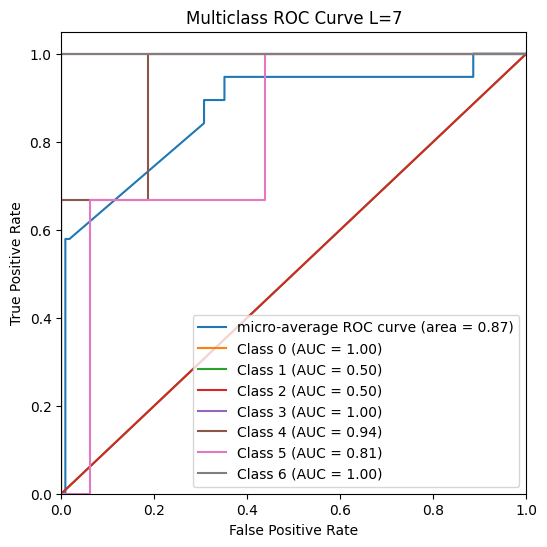


-----------------

L: 2
Optimal C: 0.3593813663804626
Optimal p: 5
Cross-validation accuracy (mean): 0.9419934640522876
Training Accuracy score: 0.9565217391304348
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 3  2  0  0  0  0  0]
 [ 0  3  0  1  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



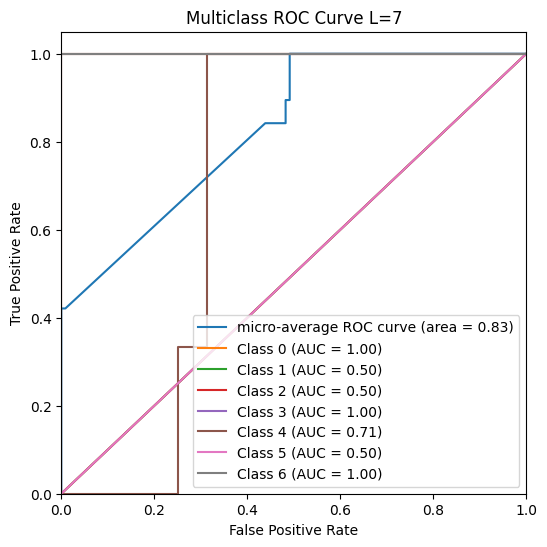


-----------------

L: 3
Optimal C: 166.81005372000558
Optimal p: 12
Cross-validation accuracy (mean): 0.9281045751633987
Training Accuracy score: 0.9855072463768116
Testing Accuracy score: 0.7894736842105263

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  3  0  1  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



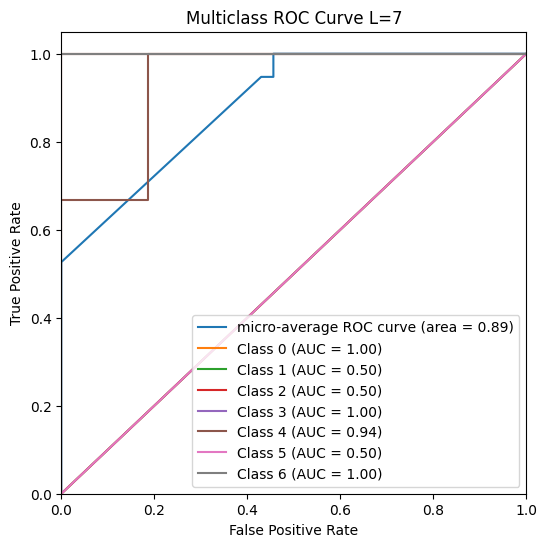


-----------------

L: 4
Optimal C: 1291.5496650148827
Optimal p: 25
Cross-validation accuracy (mean): 0.9419934640522876
Training Accuracy score: 0.9420289855072463
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  3  0  1  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  3  0  0  0  9  0]
 [ 0  0  0  0  0  0 12]] 



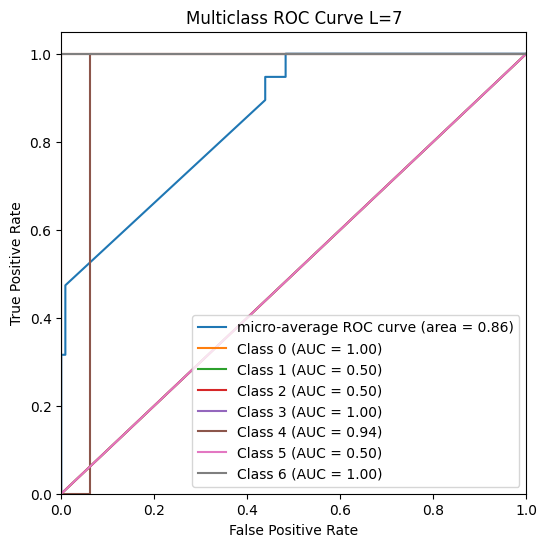


-----------------

L: 5
Optimal C: 166.81005372000558
Optimal p: 18
Cross-validation accuracy (mean): 0.9419934640522876
Training Accuracy score: 0.9855072463768116
Testing Accuracy score: 0.8421052631578947

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  3  0  1  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



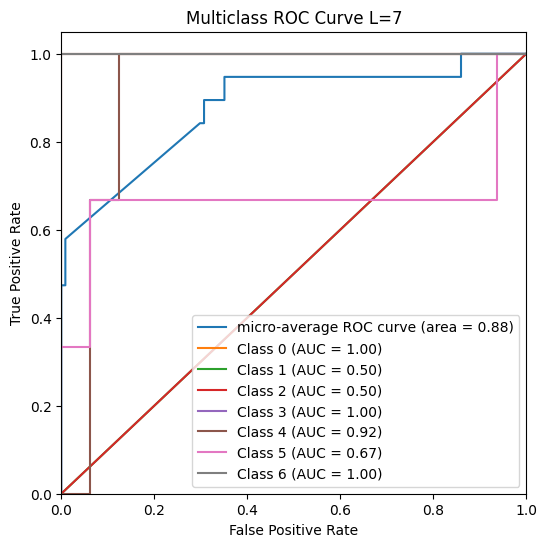


-----------------

L: 6
Optimal C: 0.3593813663804626
Optimal p: 6
Cross-validation accuracy (mean): 0.9419934640522876
Training Accuracy score: 0.9710144927536232
Testing Accuracy score: 0.8947368421052632

Confusion matrix:
 [[ 3  2  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



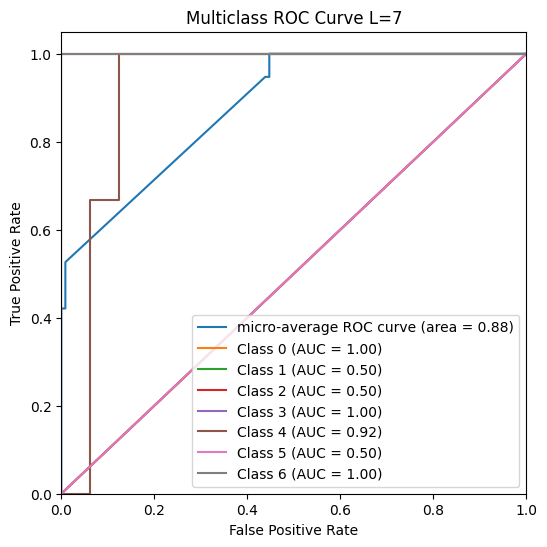


-----------------

L: 7
Optimal C: 0.3593813663804626
Optimal p: 4
Cross-validation accuracy (mean): 0.9419934640522876
Training Accuracy score: 1.0
Testing Accuracy score: 0.8947368421052632

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



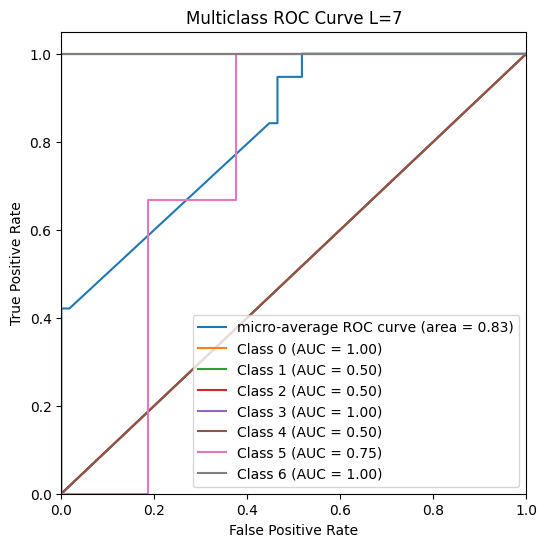


-----------------

L: 8
Optimal C: 1291.5496650148827
Optimal p: 61
Cross-validation accuracy (mean): 0.9281045751633987
Training Accuracy score: 1.0
Testing Accuracy score: 0.6842105263157895

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



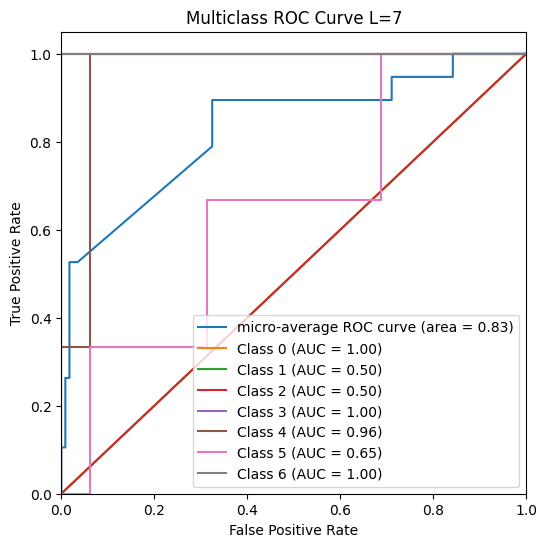


-----------------

L: 9
Optimal C: 2.782559402207126
Optimal p: 10
Cross-validation accuracy (mean): 0.9558823529411764
Training Accuracy score: 1.0
Testing Accuracy score: 0.8421052631578947

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



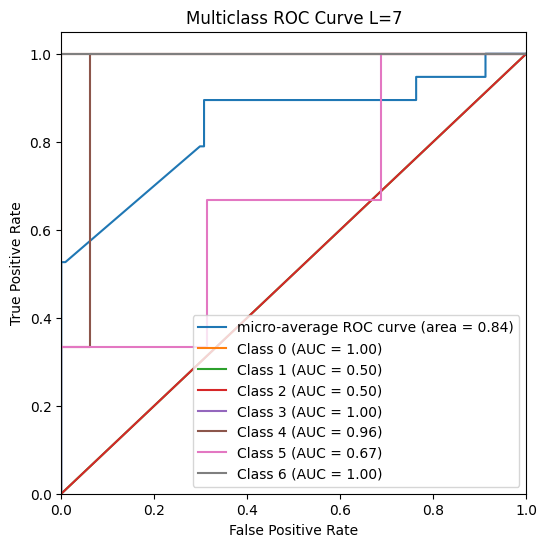


-----------------

L: 10
Optimal C: 0.3593813663804626
Optimal p: 4
Cross-validation accuracy (mean): 0.9419934640522876
Training Accuracy score: 1.0
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



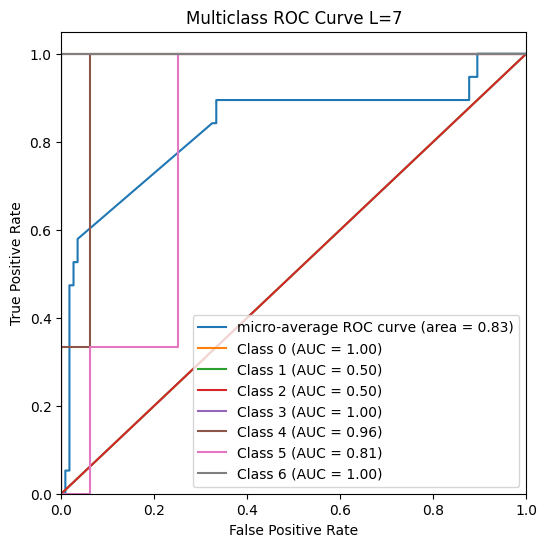


-----------------

L: 11
Optimal C: 21.54434690031882
Optimal p: 11
Cross-validation accuracy (mean): 0.9281045751633987
Training Accuracy score: 1.0
Testing Accuracy score: 0.8947368421052632

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



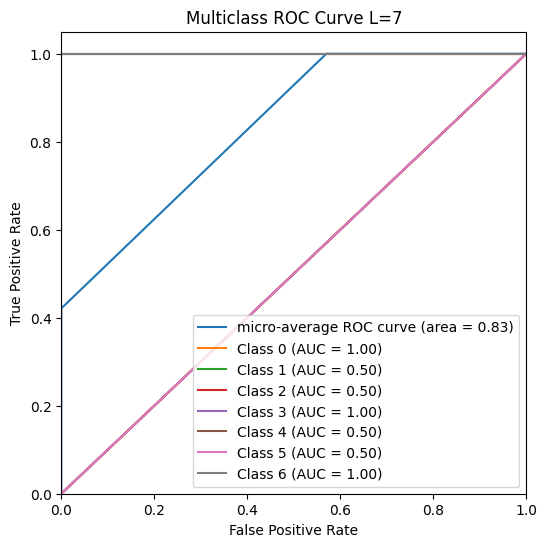


-----------------

L: 12
Optimal C: 10000.0
Optimal p: 110
Cross-validation accuracy (mean): 0.928921568627451
Training Accuracy score: 0.927536231884058
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  2  0  0 10  0  0]
 [ 0  3  0  0  0  9  0]
 [ 0  0  0  0  0  0 12]] 



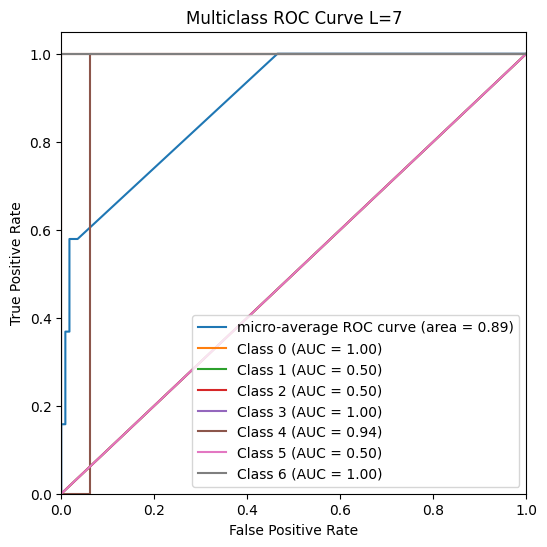


-----------------

L: 13
Optimal C: 10000.0
Optimal p: 123
Cross-validation accuracy (mean): 0.928921568627451
Training Accuracy score: 0.9420289855072463
Testing Accuracy score: 0.7894736842105263

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0  8  4  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



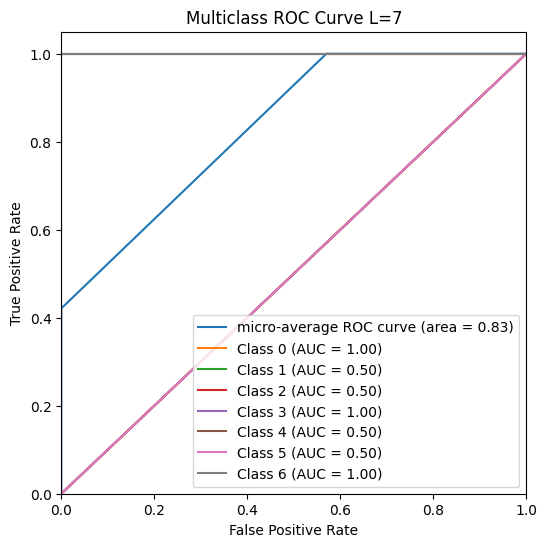


-----------------

L: 14
Optimal C: 1291.5496650148827
Optimal p: 93
Cross-validation accuracy (mean): 0.9281045751633987
Training Accuracy score: 1.0
Testing Accuracy score: 0.8947368421052632

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



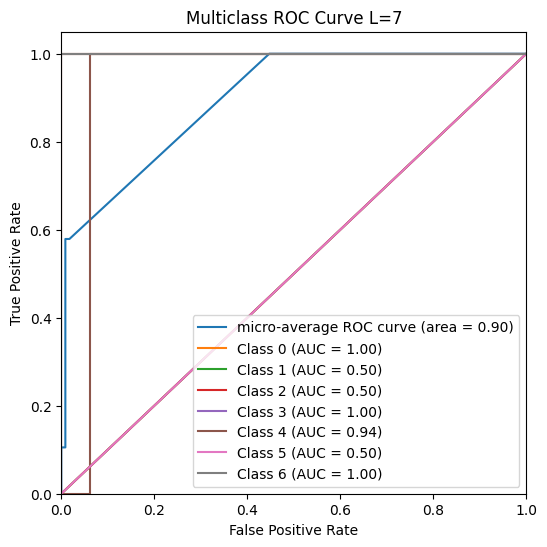


-----------------

L: 15
Optimal C: 1291.5496650148827
Optimal p: 61
Cross-validation accuracy (mean): 0.9428104575163399
Training Accuracy score: 1.0
Testing Accuracy score: 0.7894736842105263

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



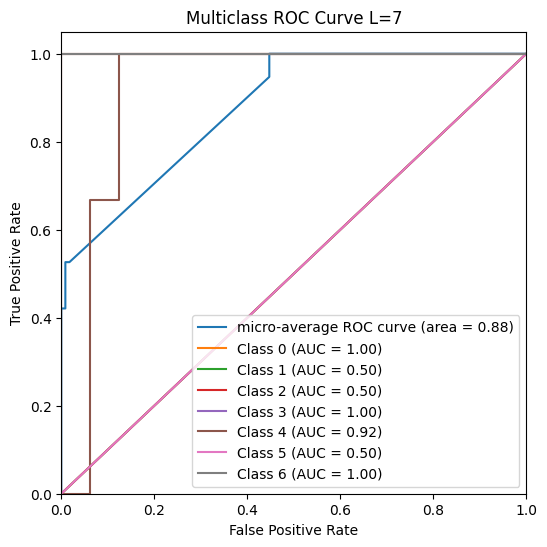


-----------------

L: 16
Optimal C: 1291.5496650148827
Optimal p: 79
Cross-validation accuracy (mean): 0.9281045751633987
Training Accuracy score: 1.0
Testing Accuracy score: 0.7894736842105263

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



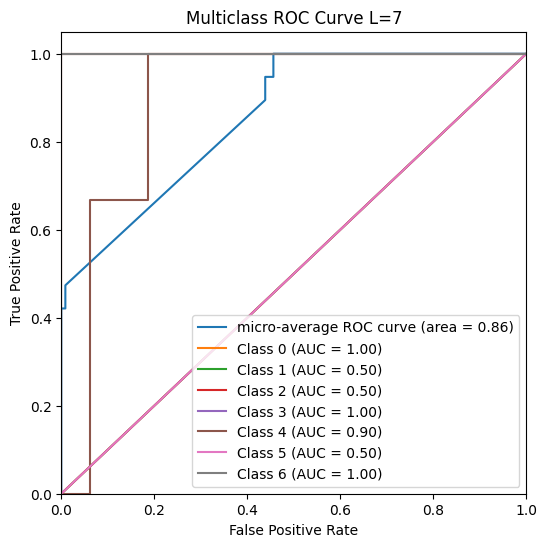


-----------------

L: 17
Optimal C: 1291.5496650148827
Optimal p: 97
Cross-validation accuracy (mean): 0.9281045751633987
Training Accuracy score: 1.0
Testing Accuracy score: 0.8421052631578947

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



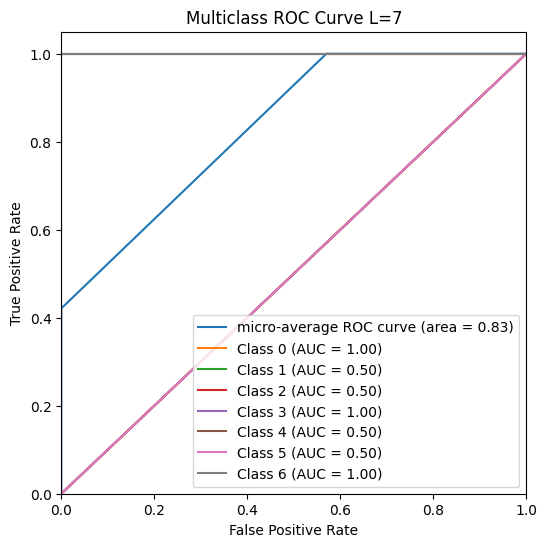


-----------------

L: 18
Optimal C: 1291.5496650148827
Optimal p: 85
Cross-validation accuracy (mean): 0.9428104575163399
Training Accuracy score: 1.0
Testing Accuracy score: 0.8947368421052632

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



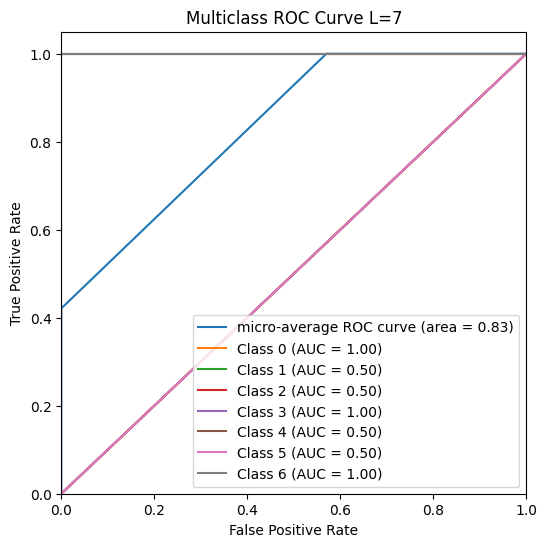


-----------------

L: 19
Optimal C: 1291.5496650148827
Optimal p: 108
Cross-validation accuracy (mean): 0.9281045751633987
Training Accuracy score: 0.9710144927536232
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  2  0  0  0 10  0]
 [ 0  0  0  0  0  0 12]] 



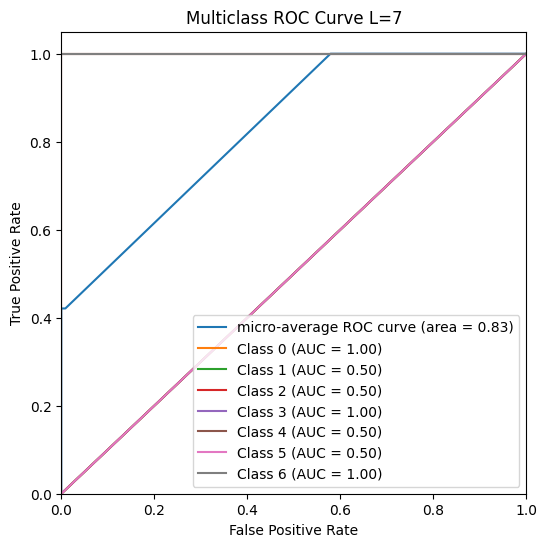


-----------------

L: 20
Optimal C: 1291.5496650148827
Optimal p: 103
Cross-validation accuracy (mean): 0.9419934640522876
Training Accuracy score: 1.0
Testing Accuracy score: 0.8947368421052632

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



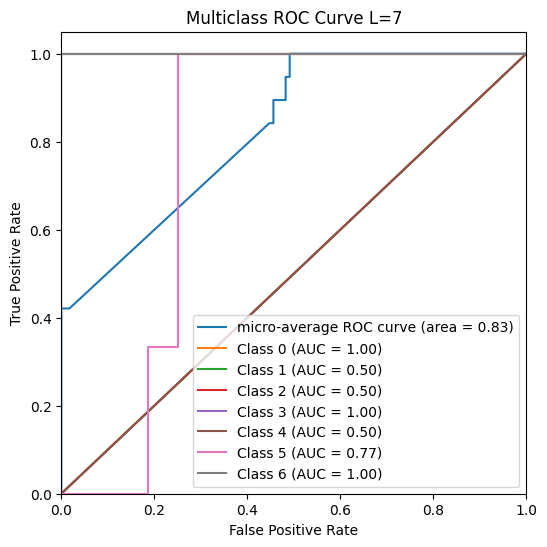


-----------------


In [250]:
mcc_models = {}

for i in list(range(20)):
    pipeline = Pipeline([
        ('scaler', sci.preprocessing.StandardScaler()),
        ('model', sci.linear_model.LogisticRegressionCV(max_iter=2000, penalty='l1', cv=sci.model_selection.StratifiedKFold(4), solver='liblinear'))
    ])

    x = derived_datasets.get(i)[0].drop(columns=['bin_ind', 'multiclass'])
    y = derived_datasets.get(i)[0]['multiclass']

    pipeline.fit(x, y)

    y_hat_train = pipeline.predict(x)
    y_hat_test = pipeline.predict(derived_datasets.get(i)[1].drop(columns=['bin_ind', 'multiclass']))

    mcc_models[i] = pipeline

    print("\nL:", i + 1)
    print("Optimal C:", pipeline.named_steps['model'].C_[0])
    print("Optimal p:", sum(pipeline.named_steps['model'].coef_[0] != 0))
    print("Cross-validation accuracy (mean):", pipeline.named_steps['model'].scores_[1].mean(axis=0)[list(pipeline.named_steps['model'].Cs_).index(pipeline.named_steps['model'].C_[0])])
    print("Training Accuracy score:", sci.metrics.accuracy_score(y, y_hat_train))
    print("Testing Accuracy score:", sci.metrics.accuracy_score(derived_datasets.get(i)[1][['multiclass']], y_hat_test))

    ##
    print(f"\nConfusion matrix:\n", sci.metrics.confusion_matrix(derived_datasets.get(i)[0]['multiclass'], y_hat_train), '\n')
    ##

    x = derived_datasets.get(i)[0].drop(columns=['bin_ind', 'multiclass'])
    y = sci.preprocessing.label_binarize(derived_datasets.get(i)[0]['multiclass'], classes=list(range(7)))
    x_test = derived_datasets.get(i)[1].drop(columns=['bin_ind', 'multiclass'])
    y_test = sci.preprocessing.label_binarize(derived_datasets.get(i)[1]['multiclass'], classes=list(range(7)))
    y_train_bin = sci.preprocessing.label_binarize(y, classes=list(range(7)))
    y_test_bin = sci.preprocessing.label_binarize(y_test, classes=list(range(7)))

    classifier = OneVsRestClassifier(pipeline)
    classifier.fit(x, y_train_bin)
    y_score = classifier.decision_function(x_test)

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(7):
        fpr[i], tpr[i], _ = sci.metrics.roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = sci.metrics.auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = sci.metrics.roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = sci.metrics.auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(6, 6))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    for i in range(7):
        plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curve L={i+1}')
    plt.legend(loc="lower right")
    plt.show()
    
    print("\n-----------------")

#### ii. Naive Bayes


L: 1
Training Accuracy score: 0.9710144927536232
Testing Accuracy score: 0.8947368421052632

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  0 11  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



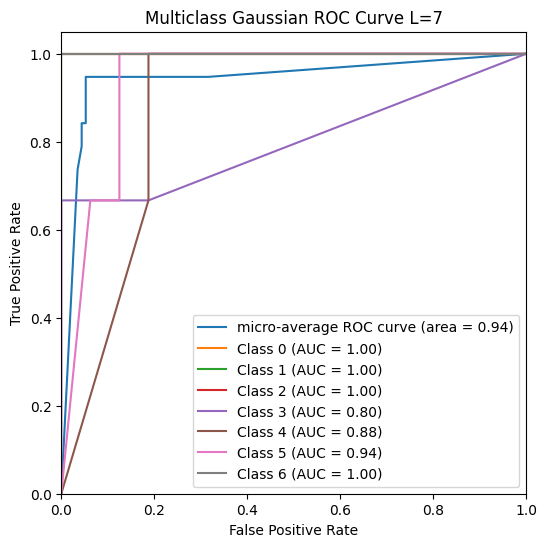


-----------------

L: 2
Training Accuracy score: 0.9710144927536232
Testing Accuracy score: 0.6842105263157895

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  0 11  0  0]
 [ 0  1  0  0  0 11  0]
 [ 0  0  0  0  0  0 12]] 



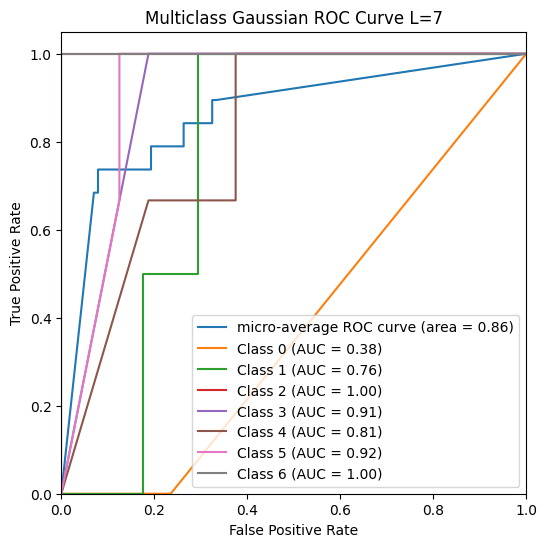


-----------------

L: 3
Training Accuracy score: 0.9565217391304348
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  0  9  2  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



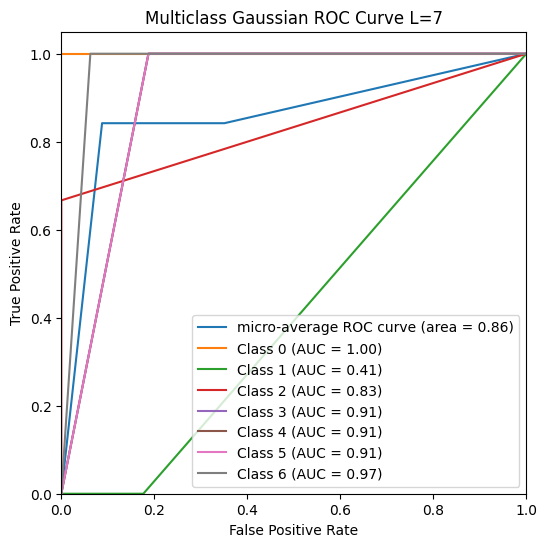


-----------------

L: 4
Training Accuracy score: 0.9710144927536232
Testing Accuracy score: 0.7894736842105263

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 10  2  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



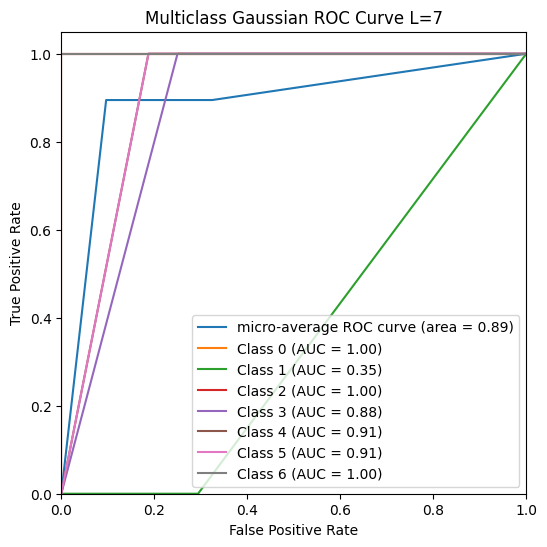


-----------------

L: 5
Training Accuracy score: 0.9855072463768116
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 11  1  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



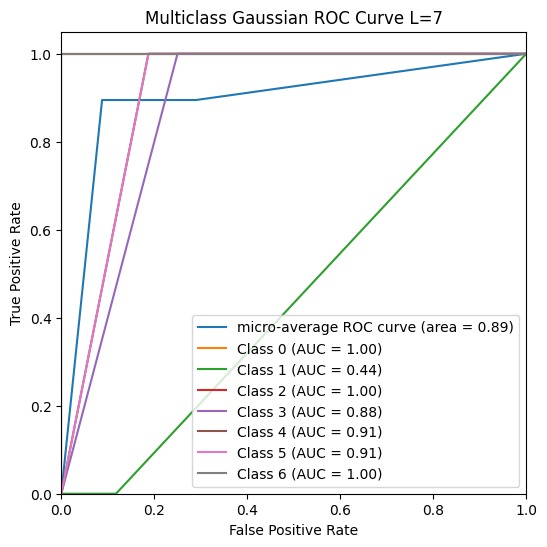


-----------------

L: 6
Training Accuracy score: 0.9710144927536232
Testing Accuracy score: 0.631578947368421

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 10  2  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



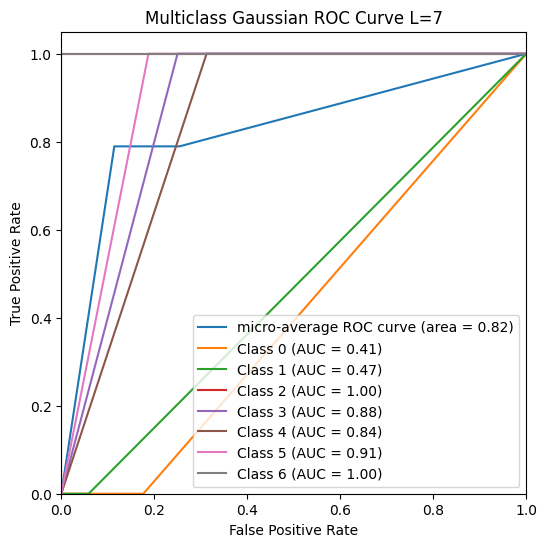


-----------------

L: 7
Training Accuracy score: 0.9855072463768116
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 11  1  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



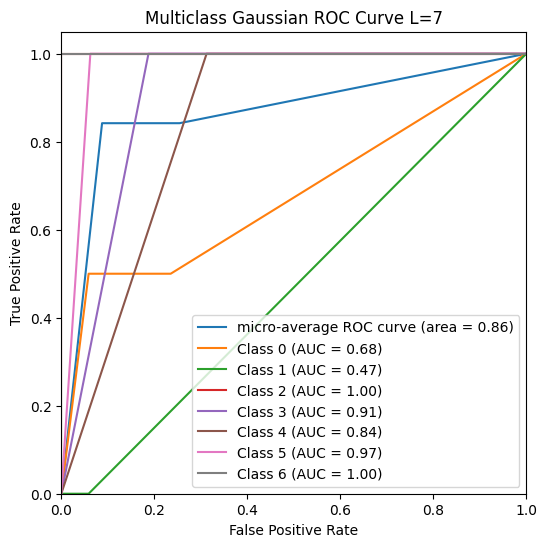


-----------------

L: 8
Training Accuracy score: 0.9855072463768116
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 11  1  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



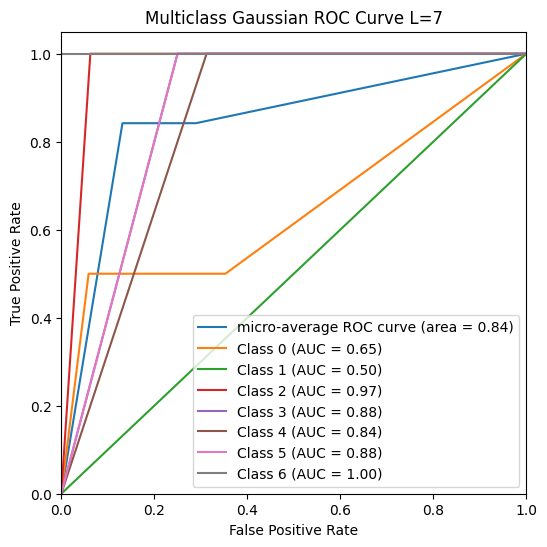


-----------------

L: 9
Training Accuracy score: 0.9855072463768116
Testing Accuracy score: 0.6842105263157895

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 11  1  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



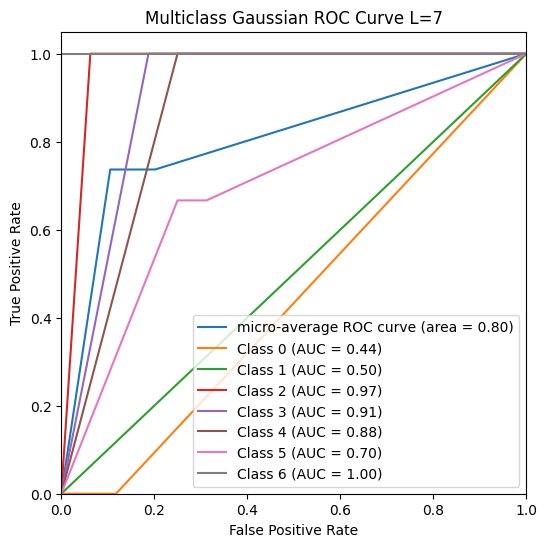


-----------------

L: 10
Training Accuracy score: 1.0
Testing Accuracy score: 0.7894736842105263

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



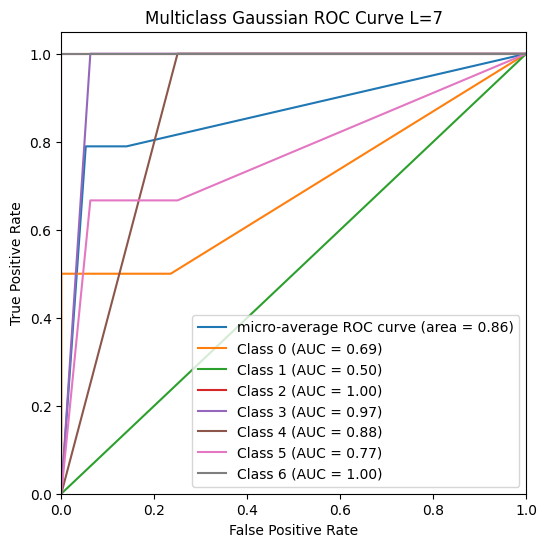


-----------------

L: 11
Training Accuracy score: 0.9710144927536232
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 10  2  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



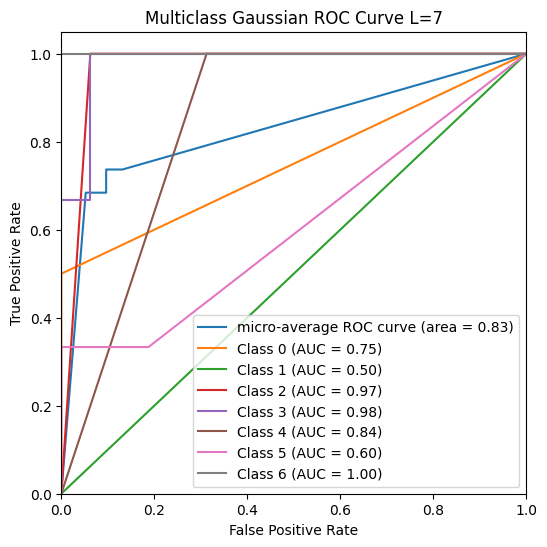


-----------------

L: 12
Training Accuracy score: 0.9710144927536232
Testing Accuracy score: 0.631578947368421

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 10  2  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



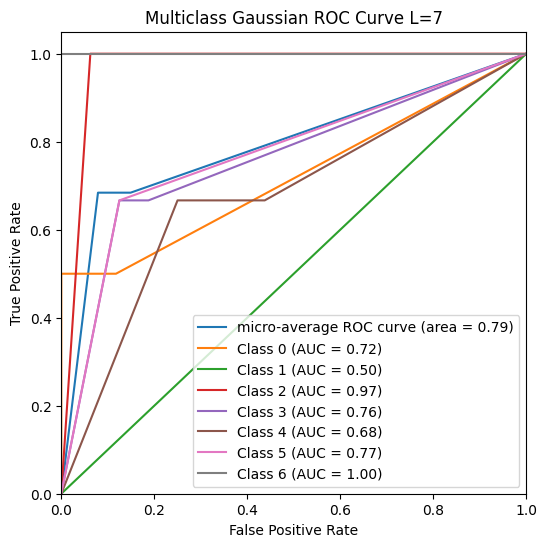


-----------------

L: 13
Training Accuracy score: 0.9855072463768116
Testing Accuracy score: 0.631578947368421

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 11  1  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



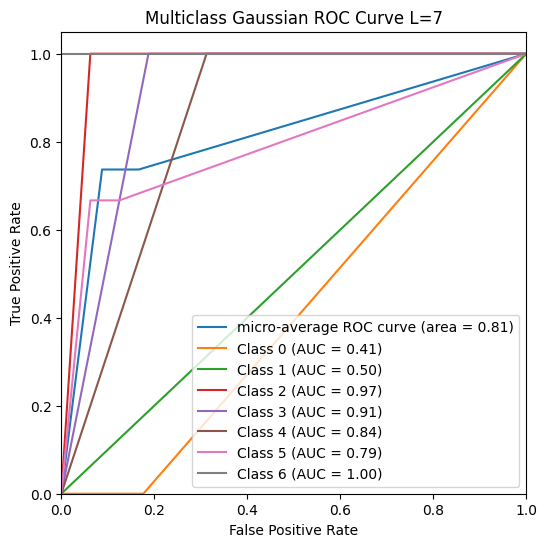


-----------------

L: 14
Training Accuracy score: 1.0
Testing Accuracy score: 0.631578947368421

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



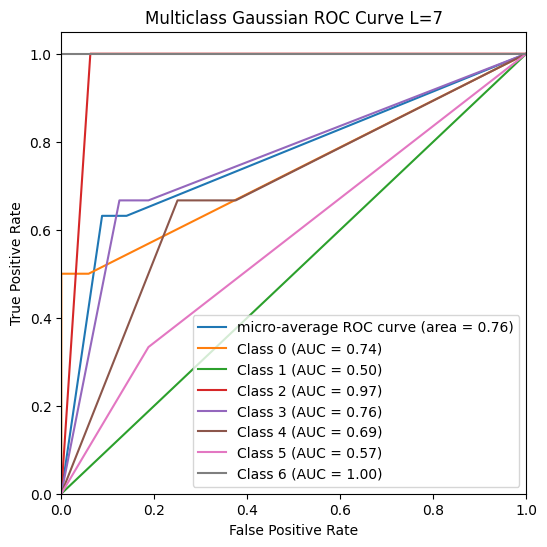


-----------------

L: 15
Training Accuracy score: 1.0
Testing Accuracy score: 0.6842105263157895

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



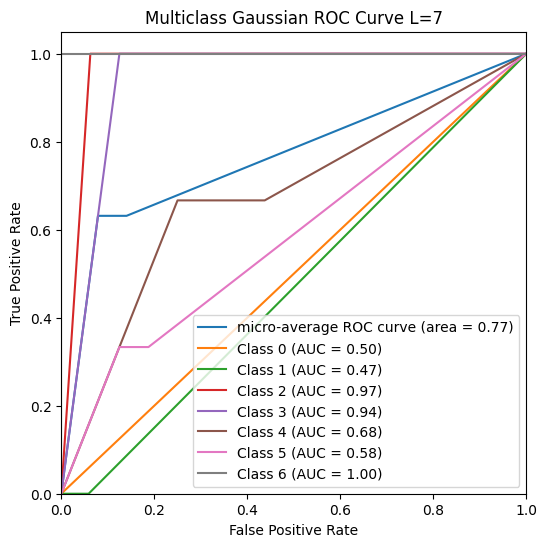


-----------------

L: 16
Training Accuracy score: 0.9855072463768116
Testing Accuracy score: 0.631578947368421

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 11  1  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



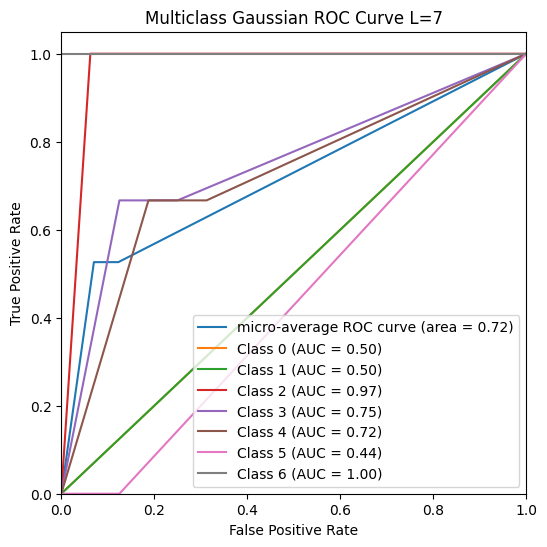


-----------------

L: 17
Training Accuracy score: 0.9855072463768116
Testing Accuracy score: 0.5263157894736842

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 11  1  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



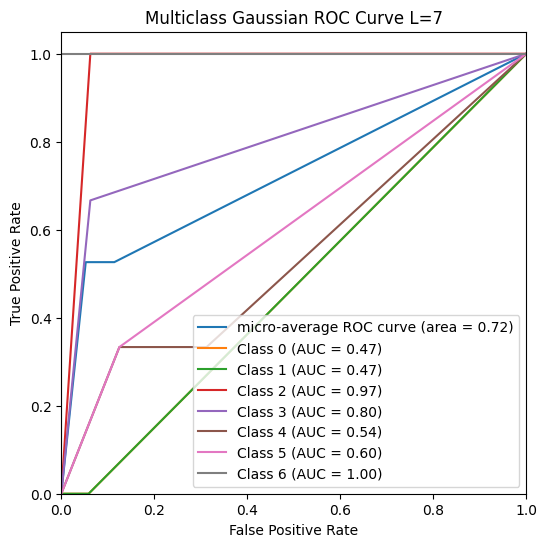


-----------------

L: 18
Training Accuracy score: 1.0
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



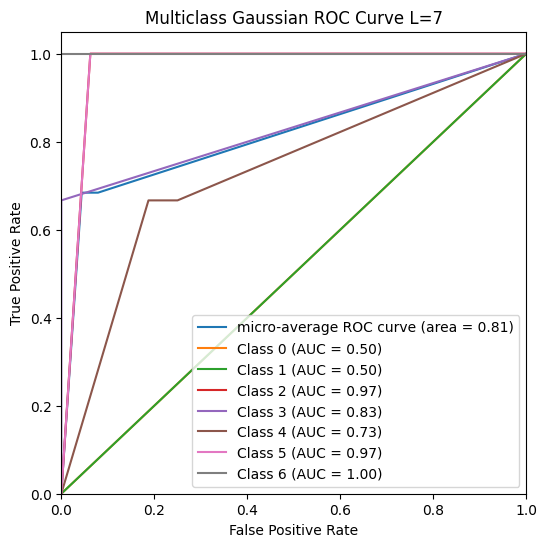


-----------------

L: 19
Training Accuracy score: 1.0
Testing Accuracy score: 0.631578947368421

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



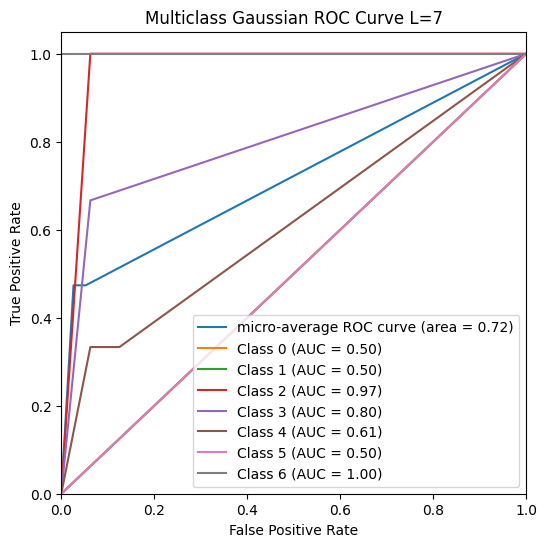


-----------------

L: 20
Training Accuracy score: 1.0
Testing Accuracy score: 0.5789473684210527

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]] 



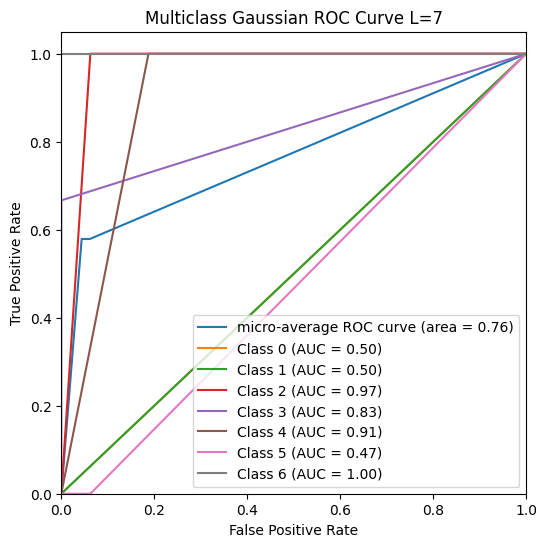


-----------------


In [279]:
for i in list(range(20)):
    pipeline = Pipeline([
        ('scaler', sci.preprocessing.StandardScaler()),
        ('model', GaussianNB())
    ])

    x = derived_datasets.get(i)[0].drop(columns=['bin_ind', 'multiclass'])
    y = derived_datasets.get(i)[0]['multiclass']

    pipeline.fit(x, y)

    feature_set = list(x.columns[(mcc_models.get(i).named_steps['model'].coef_ != 0).any(axis=0)])

    x_train_selected = x[feature_set]
    x_test_selected = derived_datasets.get(i)[1][feature_set]

    pipeline.fit(x_train_selected, y)

    y_hat_train = pipeline.predict(x_train_selected)
    y_hat_test = pipeline.predict(x_test_selected)

    print("\nL:", i + 1)
    print("Training Accuracy score:", sci.metrics.accuracy_score(y, y_hat_train))
    print("Testing Accuracy score:", sci.metrics.accuracy_score(derived_datasets.get(i)[1][['multiclass']], y_hat_test))

    ##
    print(f"\nConfusion matrix:\n", sci.metrics.confusion_matrix(derived_datasets.get(i)[0]['multiclass'], y_hat_train), '\n')
    ##

    x = derived_datasets.get(i)[0].drop(columns=['bin_ind', 'multiclass'])
    y = sci.preprocessing.label_binarize(derived_datasets.get(i)[0]['multiclass'], classes=list(range(7)))
    x_test = derived_datasets.get(i)[1].drop(columns=['bin_ind', 'multiclass'])
    y_test = sci.preprocessing.label_binarize(derived_datasets.get(i)[1]['multiclass'], classes=list(range(7)))
    y_train_bin = sci.preprocessing.label_binarize(y, classes=list(range(7)))
    y_test_bin = sci.preprocessing.label_binarize(y_test, classes=list(range(7)))

    classifier = OneVsRestClassifier(pipeline)
    classifier.fit(x, y_train_bin)
    y_score = classifier.predict_proba(x_test)

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(7):
        fpr[i], tpr[i], _ = sci.metrics.roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = sci.metrics.auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = sci.metrics.roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = sci.metrics.auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(6, 6))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    for i in range(7):
        plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass Gaussian ROC Curve L={i+1}')
    plt.legend(loc="lower right")
    plt.show()
    
    print("\n-----------------")


L: 1
Training Accuracy score: 0.8985507246376812
Testing Accuracy score: 0.8421052631578947

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 11  1  0  0]
 [ 0  1  0  1 10  0  0]
 [ 0  0  0  0  3  9  0]
 [ 0  0  0  0  0  0 12]] 



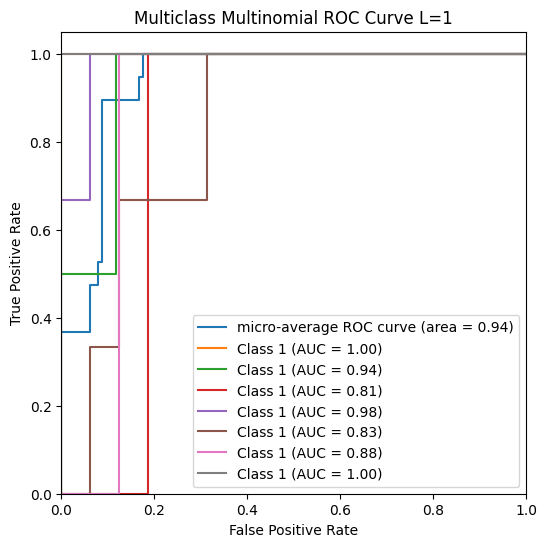


-----------------

L: 2
Training Accuracy score: 0.8840579710144928
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 10  0  2  0]
 [ 0  1  0  1  9  1  0]
 [ 0  0  0  0  2 10  0]
 [ 0  0  0  0  0  0 12]] 



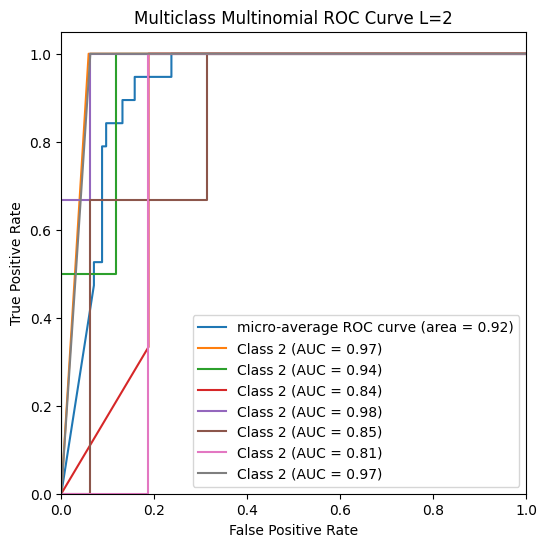


-----------------

L: 3
Training Accuracy score: 0.8985507246376812
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 11  0  1  0]
 [ 0  0  0  1 10  1  0]
 [ 0  0  0  0  3  9  0]
 [ 0  0  0  0  0  0 12]] 



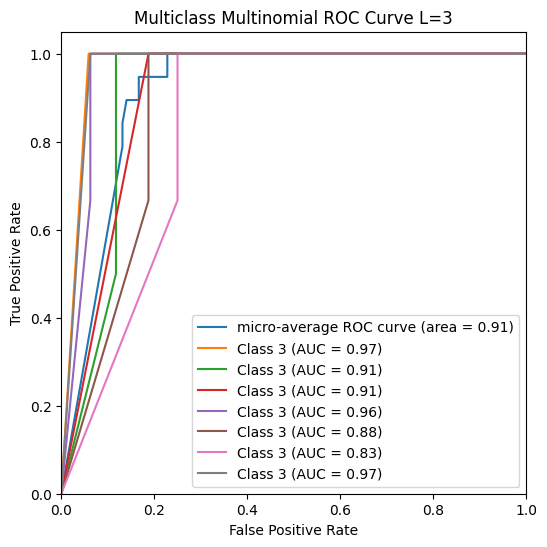


-----------------

L: 4
Training Accuracy score: 0.9130434782608695
Testing Accuracy score: 0.7894736842105263

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 10  0  2  0]
 [ 0  0  0  0 11  1  0]
 [ 0  0  0  0  2 10  0]
 [ 0  0  0  0  0  0 12]] 



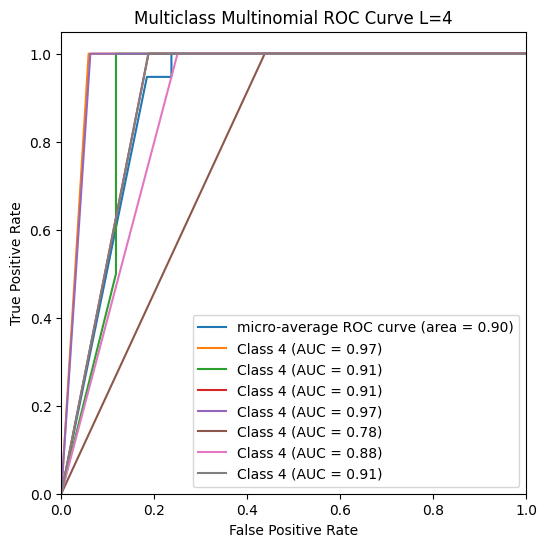


-----------------

L: 5
Training Accuracy score: 0.927536231884058
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 1  0  0  1  9  1  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



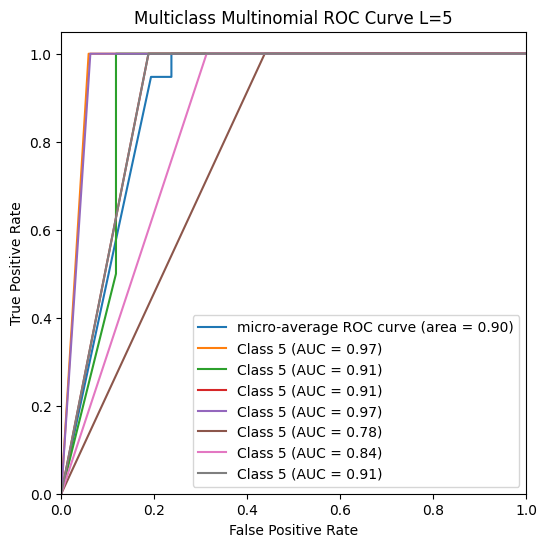


-----------------

L: 6
Training Accuracy score: 0.9710144927536232
Testing Accuracy score: 0.7894736842105263

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



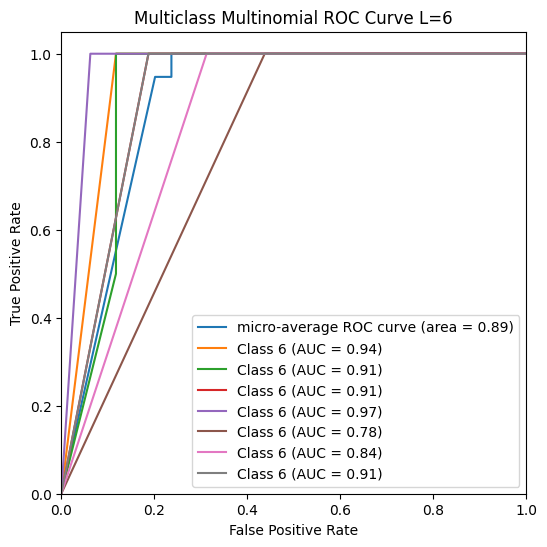


-----------------

L: 7
Training Accuracy score: 0.9420289855072463
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  1 10  1  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



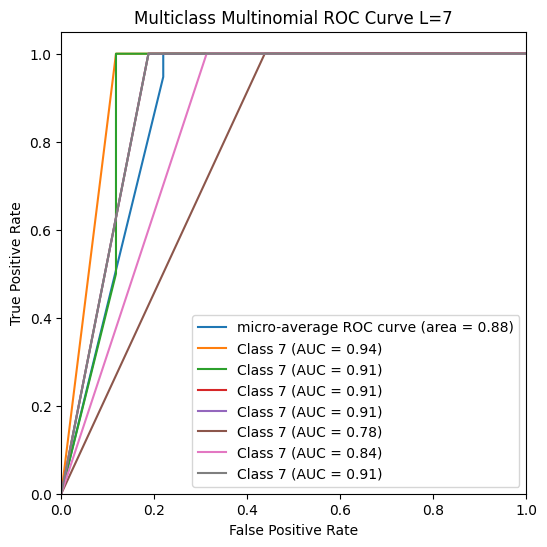


-----------------

L: 8
Training Accuracy score: 0.9420289855072463
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 1  0  0  1 10  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



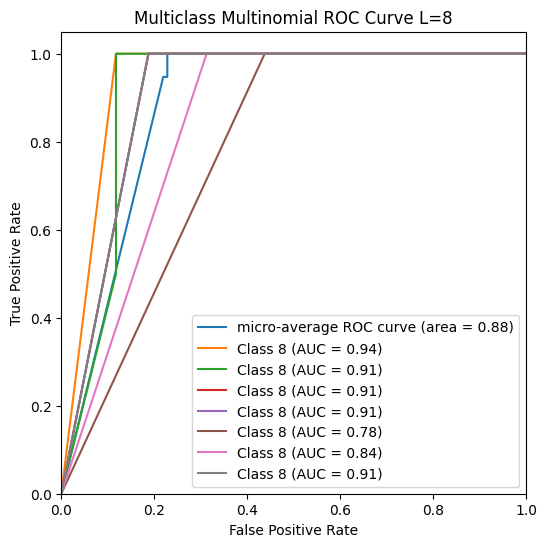


-----------------

L: 9
Training Accuracy score: 0.9420289855072463
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 1  0  0  1 10  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



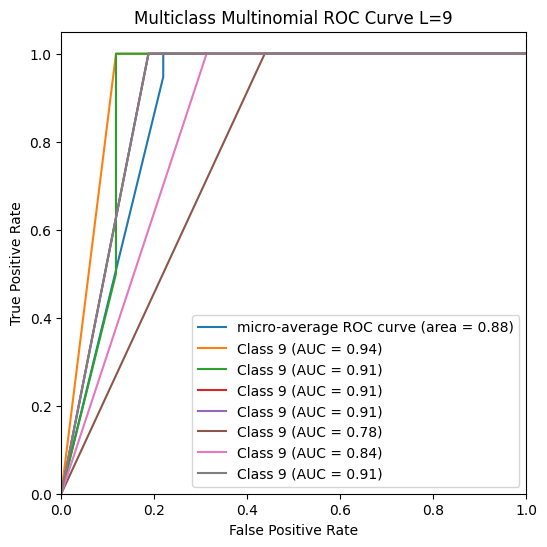


-----------------

L: 10
Training Accuracy score: 0.927536231884058
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 10  0  2  0]
 [ 0  0  0  1 11  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



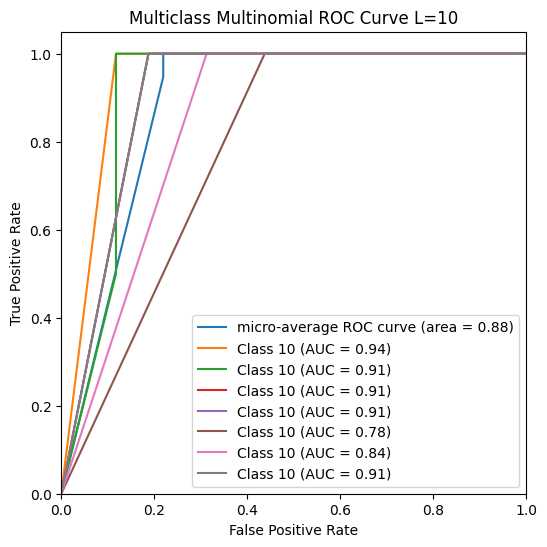


-----------------

L: 11
Training Accuracy score: 0.9420289855072463
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 11  0  1  0]
 [ 0  0  0  0 11  1  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



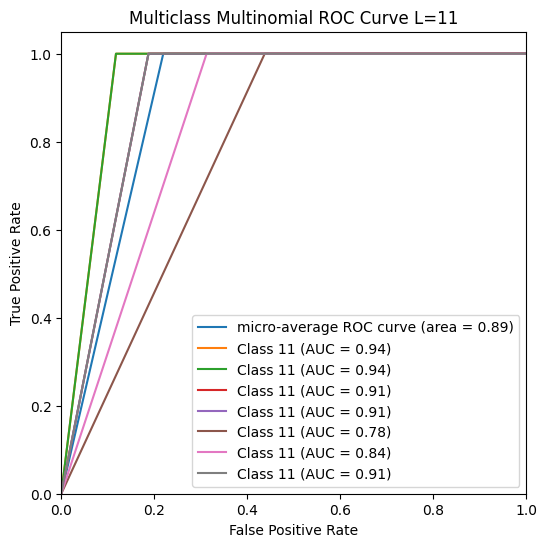


-----------------

L: 12
Training Accuracy score: 0.9420289855072463
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  1 11  0  0]
 [ 0  0  0  0  2 10  0]
 [ 0  0  0  0  0  0 12]] 



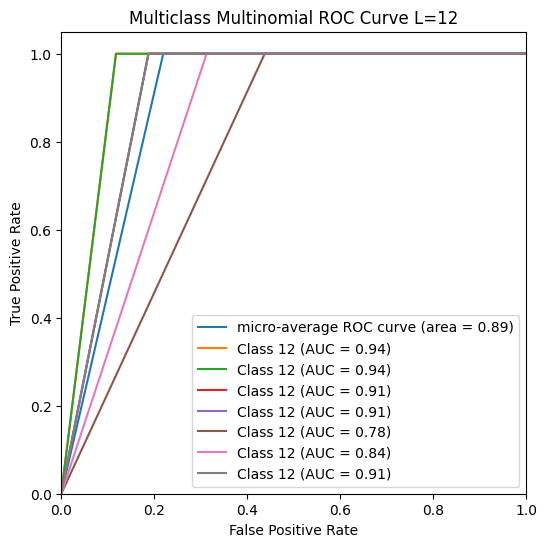


-----------------

L: 13
Training Accuracy score: 0.927536231884058
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 11  0  1  0]
 [ 0  0  0  1 10  1  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



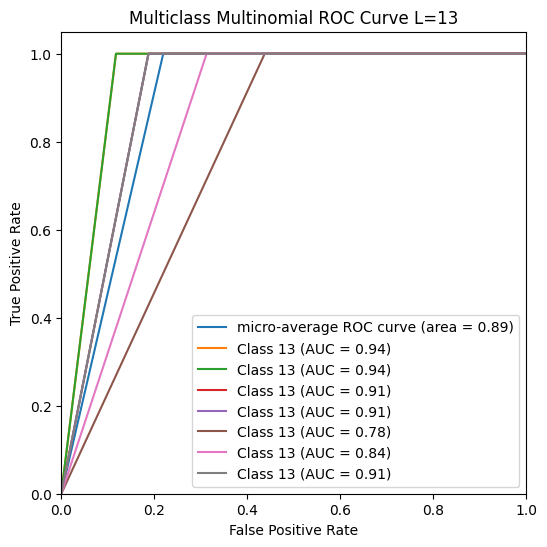


-----------------

L: 14
Training Accuracy score: 0.9565217391304348
Testing Accuracy score: 0.7894736842105263

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  1 11  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



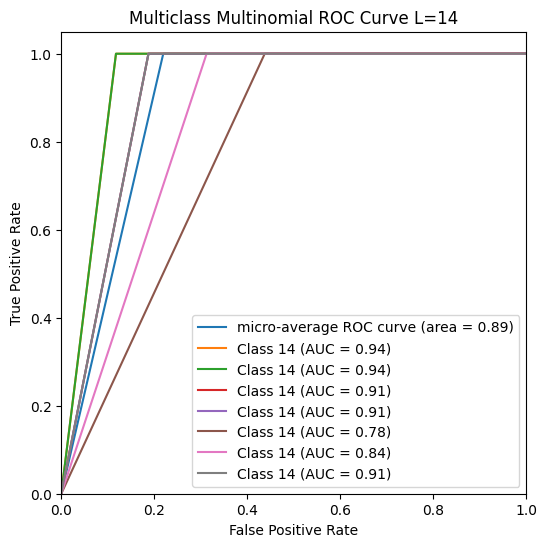


-----------------

L: 15
Training Accuracy score: 0.9710144927536232
Testing Accuracy score: 0.8421052631578947

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



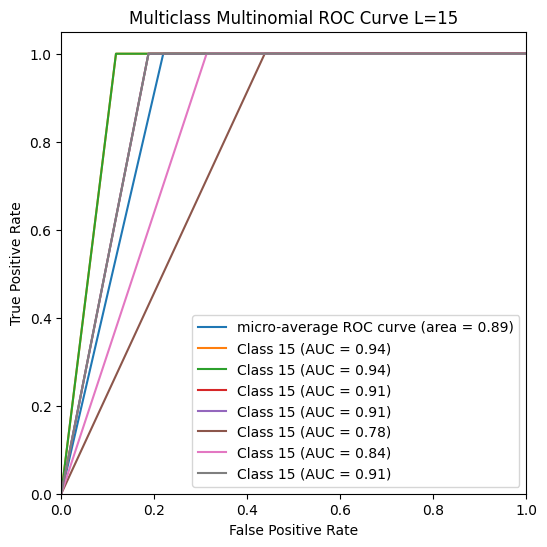


-----------------

L: 16
Training Accuracy score: 0.9565217391304348
Testing Accuracy score: 0.8421052631578947

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  1 11  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



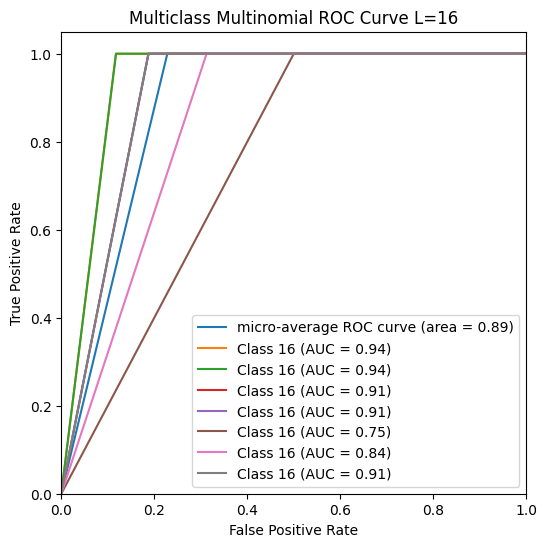


-----------------

L: 17
Training Accuracy score: 0.9420289855072463
Testing Accuracy score: 0.8947368421052632

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  1 10  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



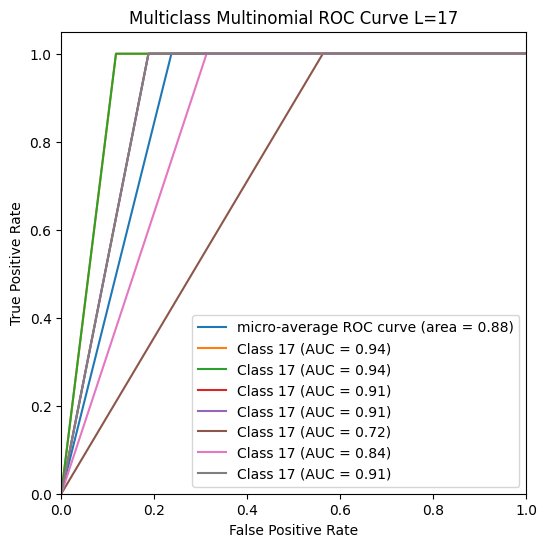


-----------------

L: 18
Training Accuracy score: 0.9565217391304348
Testing Accuracy score: 0.7368421052631579

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 1  0  0  0 11  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



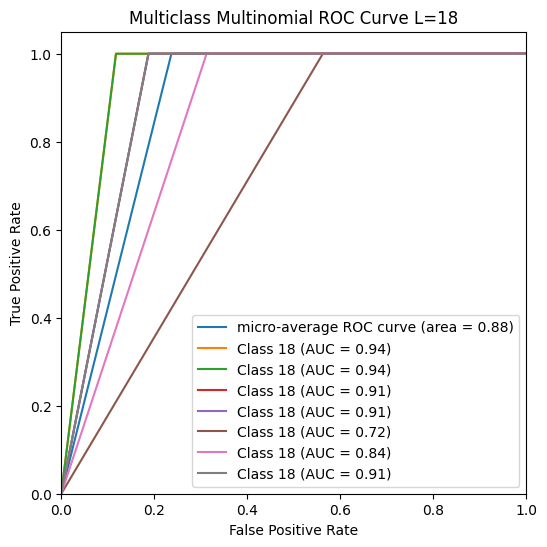


-----------------

L: 19
Training Accuracy score: 0.9420289855072463
Testing Accuracy score: 0.7894736842105263

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 1  0  0  1 10  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



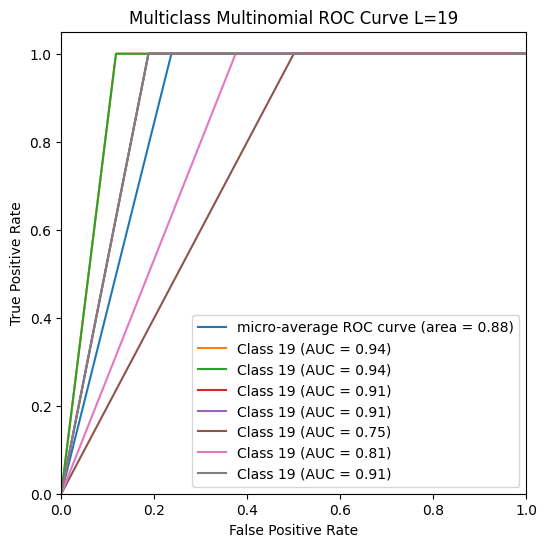


-----------------

L: 20
Training Accuracy score: 0.9420289855072463
Testing Accuracy score: 0.7894736842105263

Confusion matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 1  0  0  1 10  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]] 



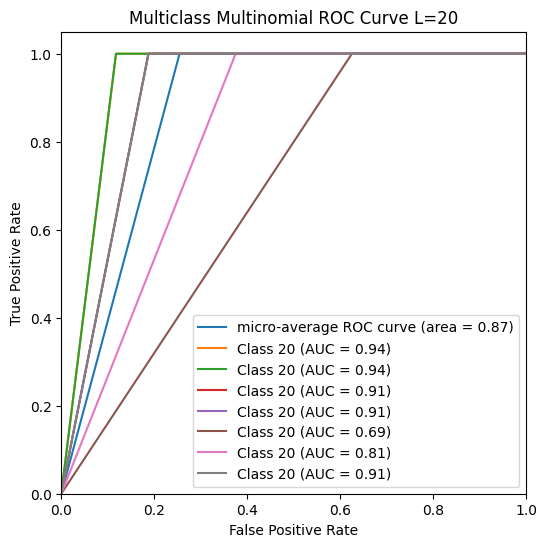


-----------------


In [281]:
for i in list(range(1,21)):

    train_split = {}
    test_split = {}

    for dict in [train_data, test_data]:
        for id, dataframe in dict.items():
            temp = pd.DataFrame()
            chunk_size = dataframe.shape[0] // i
            for j in range(i):
                start = j * chunk_size
                end = (j + 1) * chunk_size if j < i - 1 else dataframe.shape[0]
                chunk = dataframe.iloc[start:end]
                chunk = chunk.add_suffix(f'_{j}')
                temp = pd.concat([temp, chunk], axis=1)                

            if dict == train_data:
                train_split[id] = temp
            else:
                test_split[id] = temp

    train_split = extract_features(train_split, 1)
    test_split = extract_features(test_split, 1)

    train_split = pd.DataFrame(train_split).T
    test_split = pd.DataFrame(test_split).T

    for dataframe in [train_split, test_split, data_split]:
        dataframe['bin_ind'] = [j.startswith('bending') for j in dataframe.index]
        dataframe['multiclass'] = [class_map.get(j.split('_')[0]) for j in dataframe.index]
    
    pipeline = Pipeline([
        ('scaler', None),
        ('model', MultinomialNB())
    ])

    x = train_split.drop(columns=['bin_ind', 'multiclass'])
    y = train_split['multiclass']
    x_test = test_split.drop(columns=['multiclass', 'bin_ind'])
    y_test = test_split['multiclass']

    pipeline.fit(x, y)

    feature_set = list(x.columns[(mcc_models.get(i - 1).named_steps['model'].coef_ != 0).any(axis=0)])


    x_train_selected = x[feature_set]
    x_test_selected = x_test[feature_set]

    pipeline.fit(x_train_selected, y)

    y_hat_train = pipeline.predict(x_train_selected)
    y_hat_test = pipeline.predict(x_test_selected)

    print("\nL:", i)
    print("Training Accuracy score:", sci.metrics.accuracy_score(y, y_hat_train))
    print("Testing Accuracy score:", sci.metrics.accuracy_score(y_test, y_hat_test))

    ##
    print(f"\nConfusion matrix:\n", sci.metrics.confusion_matrix(y, y_hat_train), '\n')
    ##

    y = sci.preprocessing.label_binarize(y, classes=list(range(7)))
    y_test = sci.preprocessing.label_binarize(y_test, classes=list(range(7)))
    y_train_bin = sci.preprocessing.label_binarize(y, classes=list(range(7)))
    y_test_bin = sci.preprocessing.label_binarize(y_test, classes=list(range(7)))

    classifier = OneVsRestClassifier(pipeline)
    classifier.fit(x, y_train_bin)
    y_score = classifier.predict_proba(x_test)

    fpr = {}
    tpr = {}
    roc_auc = {}
    for j in range(7):
        fpr[j], tpr[j], _ = sci.metrics.roc_curve(y_test_bin[:, j], y_score[:, j])
        roc_auc[j] = sci.metrics.auc(fpr[j], tpr[j])

    fpr["micro"], tpr["micro"], _ = sci.metrics.roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = sci.metrics.auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(6, 6))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    for j in range(7):
        plt.plot(fpr[j], tpr[j], label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[j]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass Multinomial ROC Curve L={i}')
    plt.legend(loc="lower right")
    plt.show()
    
    print("\n-----------------")

In [270]:
for k, v in train_data.items():
    print(v)

     avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0        42.00       0.71      21.25       0.43      30.00       0.00
1        41.50       0.50      20.25       1.48      31.25       1.09
2        41.50       0.50      14.25       1.92      33.00       0.00
3        40.75       0.83      15.75       0.43      33.00       0.00
4        40.00       0.71      20.00       2.74      32.75       0.43
..         ...        ...        ...        ...        ...        ...
475      42.50       0.50      20.00       0.82      36.00       0.00
476      42.67       0.47      21.00       0.00      36.33       0.47
477      44.33       0.94      21.00       0.00      36.33       0.47
478      45.25       0.43      26.75       1.79      36.00       0.00
479      47.25       0.83      29.75       0.43      35.25       1.30

[480 rows x 6 columns]
     avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0        47.33       0.47      28.00       0.82      34.25       1

#### ii. Comparison

Logistic Regression with L1 regularization handles high-dimensional data well by shrinking irrelevant coefficients, but needs enough data to reliably cross-validate and avoid overfitting. Multinomial Naive Bayes thrives on small, sparse, and discrete datasets, making it well-suited here—especially if the features resemble counts or frequencies. Gaussian Naive Bayes, on the other hand, struggles in high-dimensional settings due to its sensitivity to multicollinearity and the burden of estimating too many parameters.

Despite the assumptions of feature independence and discrete data (which fail in this dataset), the Multinomial Naive Bayes outperforms the Gaussian Naive Bayes in inference, as the former models generalize better while the latter tends to overfit. The multiclass Logistic Regression model also shows signs of overfitting but remains more generalized on average, testing at a similar accuracy to the Multinomial NB. 

Notably, I’m using the Lasso-selected feature set from each value of L as input to the Multinomial NB. That said, there may exist a more suitable feature set specifically for the NB models, which could allow them to outperform Logistic Regression. I understand that Multinomial NB performs optimally when the input features are discrete and represent count-based or frequency-based data, as this aligns with its underlying assumptions. Based on that I would opt to use the logistic regression with cross-fold validation.

## 3. ISLR 4.8.3

Gaussian density * pi(subcript)'k'-> take log of function makes the coefficient of the gaussian density a quadratic of (x- M(subscript)k) Therefore the Bayes classifier is a quadratic functio,

## 4. ISLR 4.8.7

var(X) = 36 -> std(X) = 6; p(Xdividend) 

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9

**REFCV:** https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

**Stratified k Fold:** https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

**Newton-Raphson MLE:** https://sakai.unc.edu/access/content/group/3d1eb92e-7848-4f55-90c3-7c72a54e7e43/public/docs/lectures/lecture12.htm

**Logistic Regression CV:** https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

**ROC Score:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

**Multiclass ROC:** https://scikit-learn.org/0.15/auto_examples/plot_roc.html